In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

%matplotlib inline

In [2]:
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

import sklearn.linear_model as skl
import sklearn.model_selection as skm
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, SplineTransformer
from sklearn.pipeline import Pipeline

In [ ]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM)

from ISLP.models import bs
from ISLP.pygam import (plot as plot_gam,
                        anova as anova_gam)


## Conceptual

### **Q1.**

**(a)** For $x \leq \zeta $ the term $(x - \zeta)^3_+$ vanishes, so the cubic polynomial $f_1(x)$ that satisfies $f(x) = f_1(x)$:
$$
f(x) = \beta_0 + \beta_1 x+ \beta_2 x^2 + \beta_3 x^3 \\
f_1(x) = a_1 + b_1 x+ c_1 x^2 + d_1 x^3 \\
$$
Has the following coefficients:
$$
a_1 =\beta_0  \qquad b_1 = \beta_1 \\ 
c_1 =\beta_2 \qquad d_1 = \beta_3 \\
$$
$$
f_1(x) = \beta_0 + \beta_1 x+ \beta_2 x^2 + \beta_3 x^3
$$


**(b)** For $x \gt \zeta $ the term $(x - \zeta)^3_+$ equals $(x - \zeta)^3$ which can be expanded into:
$$
(x - \zeta)^3 = x^3 -3x^2 \zeta + 3x\zeta^2 - \zeta^3
$$
Then $f(x)$ takes the form:
$$
\begin{align*}
f(x) &= \beta_0 + \beta_1 x+ \beta_2 x^2 + \beta_3 x^3 + \beta_4 (x - \zeta)^3 \\
 &= \beta_0 + \beta_1 x+ \beta_2 x^2 + \beta_3 x^3 +\beta_4 x^3 -3 \beta_4 \zeta x^2+ 3\beta_4\zeta^2 x- \beta_4\zeta^3 \\
 &= (\beta_0 - \beta_4 \zeta^3) + (\beta_1 + 3 \beta_4 \zeta^2) x+ (\beta_2-3\beta_4\zeta) x^2 + (\beta_3+\beta_4) x^3 
\end{align*}
$$
For $f_2(x) = f(x)$ to be true
$$
f_2(x) =  a_2 + b_2 x+ c_2 x^2 + d_2 x^3 = (\beta_0 - \beta_4 \zeta^3) + (\beta_1 + 3 \beta_4 \zeta^2) x+ (\beta_2-3\beta_4\zeta) x^2 + (\beta_3+\beta_4) x^3 \\
$$
The coefficients have to be:
$$
a_2 = \beta_0 - \beta_4 \zeta^3 \qquad b_2 = \beta_1 + 3 \beta_4 \zeta^2 \\ 
c_2 = \beta_2 - 3\beta_4\zeta \qquad d_2 = \beta_3+\beta_4
$$
$$
f_2(x) = (\beta_0 - \beta_4 \zeta^3) + (\beta_1 + 3 \beta_4 \zeta^2) x+ (\beta_2-3\beta_4\zeta) x^2 + (\beta_3+\beta_4) x^3 
$$

**(c)** By plugging $\zeta$ into $f_1$ we get
$$
f_1(\zeta) = \beta_0 + \beta_1 \zeta+ \beta_2 \zeta^2 + \beta_3 \zeta^3 \\
$$
Then into $f_2$
$$
\begin{align*}
f_2(\zeta) &= (\beta_0 - \beta_4 \zeta^3) + (\beta_1 + 3 \beta_4 \zeta^2) \zeta+ (\beta_2-3\beta_4\zeta) \zeta^2 + (\beta_3+\beta_4) \zeta^3 \\ 

 &= \beta_0 - \beta_4 \zeta^3 + \beta_1 \zeta + 3 \beta_4 \zeta^3+ \beta_2 \zeta^2 - 3\beta_4\zeta^3 + \beta_3 \zeta^3+ \beta_4 \zeta^3 \\

 &= \beta_0 + \beta_1 \zeta + \beta_2 \zeta^2 + \beta_3 \zeta^3
\end{align*}
$$
We can see that $f_1(\zeta) = f_2(\zeta)$ and that $f(x)$ is continous at $\zeta$.

**(d)** We'll start by taking the derivative of $f_1'(x)$ and $f_2'(x)$
$$
f_1'(x) = \beta_1 + 2\beta_2 x + 3\beta_3 x^2 \\

f_2'(x) = (\beta_1 + 3 \beta_4 \zeta^2) + 2(\beta_2-3\beta_4\zeta) x + 3(\beta_3+\beta_4) x^2
$$

Plugging in $\zeta$ into both functions we get:
$$
f_1'(\zeta) = \beta_1 + 2\beta_2 \zeta + 3\beta_3 \zeta^2
$$
And 
$$
\begin{align*}
f_2'(\zeta) &= (\beta_1 + 3 \beta_4 \zeta^2) + 2(\beta_2-3\beta_4\zeta) \zeta + 3(\beta_3+\beta_4) \zeta^2 \\
&= \beta_1 + 3\beta_4 \zeta^2 + 2\beta_2 \zeta - 6\beta_4\zeta^2 + 3\beta_3 \zeta^2 + 3\beta_4 \zeta^2 \\
&= \beta_1 + 2\beta_2 \zeta + 3\beta_3 \zeta^2
\end{align*}
$$

We can see that 
$$
f_1'(\zeta) = f_2'(\zeta) = \beta_1 + 2\beta_2 \zeta + 3\beta_3 \zeta^2
$$
and that $f'(x)$ is continous at $\zeta$.

**(e)** We'll differentiate again to get $f_1''(x)$ and $f_2''(x)$
$$
f_1''(x) =  2\beta_2 + 6\beta_3 x \\

f_2''(x) =  2(\beta_2-3\beta_4\zeta) + 6(\beta_3+\beta_4) x
$$

Plugging in $\zeta$ into both functions we get:
$$
f_1''(\zeta) = 2\beta_2 + 6\beta_3 \zeta
$$
And 
$$
\begin{align*}
f_2''(\zeta) &= 2(\beta_2-3\beta_4\zeta)  + 6(\beta_3+\beta_4) \zeta \\
&= 2\beta_2 - 6\beta_4 \zeta + 6 \beta_3 \zeta + 6\beta_4\zeta\\
&= 2\beta_2 + 6\beta_3 \zeta
\end{align*}
$$

We can see that 
$$
f_1''(\zeta) = f_2''(\zeta) = 2\beta_2 + 6\beta_3 \zeta
$$
and that $f''(x)$ is continous at $\zeta$.

### **Q2.**

We'll generate some values to use in our sketches below.

In [4]:
rng = np.random.default_rng(42)

size = 15
age = rng.normal(0, 1, size)
eps = rng.normal(0, 3, size)
y = 4*age + 0.5* age**2 * -0.6 * age**3+ eps

**(a)** For $\lambda = \infty, m = 0$, the penalty can only be minimized when $g^{(0)}$ is equal to $0$, so 
$$
g(x) = 0
$$

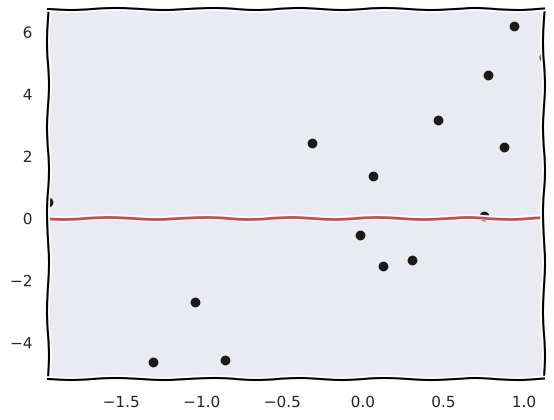

In [5]:
with plt.xkcd():
    plt.rcParams['font.family'] = 'DejaVu Sans' # to get rid of xkcd font warnings
    fig, ax = plt.subplots()
    ax.scatter(age, y, c='k')
    
    xs = np.linspace(-2, 2, 100)
    ax.plot(xs, np.zeros_like(xs), 'r')
    ax.set_xlim([age.min(), age.max()]);

**(b)** For $\lambda = \infty, m = 1$, the penalty can only be minimized when $g^{(1)}$ the first derivative of $g$ is equal to $0$, so $g$ is just a constant that minimizes the RSS term.

That constant is of course the mean of the response data points.
$$
g(x) = \bar y
$$

In [6]:
y.mean()

0.6994847223839016

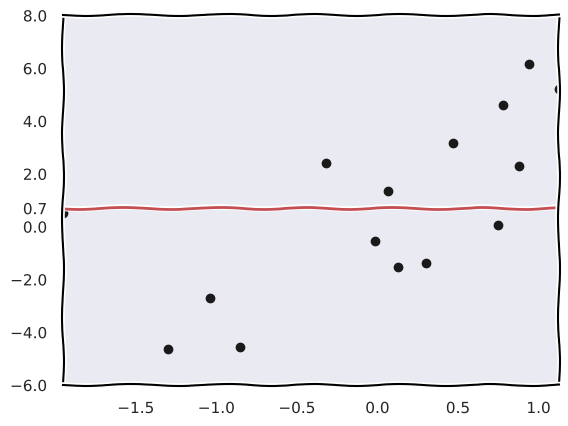

In [7]:
with plt.xkcd():
    plt.rcParams['font.family'] = 'DejaVu Sans' # to get rid of xkcd font warnings
    
    fig, ax = plt.subplots()
    ax.scatter(age, y, c='k')
    
    xs = np.linspace(-2, 2, 100)
    ax.plot(xs, np.full_like(xs, y.mean()), 'r')
    
    yticks = np.append(ax.get_yticks(), y.mean())
    ax.set_yticks(np.sort(yticks))
    ax.set_xlim([age.min(), age.max()]);

**(c)** For $\lambda = \infty, m = 2$, the penalty can only be minimized when $g^{(2)}$ the second derivative of $g$ is equal to $0$, so $g$ is a linear function that minimizes the RSS term
$$
g(x) = \beta_0 + \beta_1 x
$$

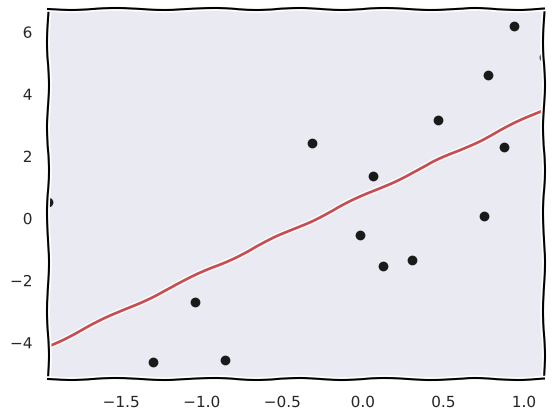

In [8]:
with plt.xkcd():
    plt.rcParams['font.family'] = 'DejaVu Sans' # to get rid of xkcd font warnings
    
    fig, ax = plt.subplots()
    ax.scatter(age, y, c='k')
    
    xs = np.linspace(-2, 2, 100)
    
    results = sm.OLS(y, sm.add_constant(age)).fit()
    ax.plot(xs, results.predict(sm.add_constant(xs)), 'r')
    
    ax.set_xlim([age.min(), age.max()]);

**(d)** For $\lambda = \infty, m = 3$, the penalty can only be minimized when $g^{(3)}$ the third derivative of $g$ is equal to $0$, so $g$ is a quadratic function that minimizes the RSS term
$$
g(x) = \beta_0 + \beta_1 x + \beta_2 x^2
$$

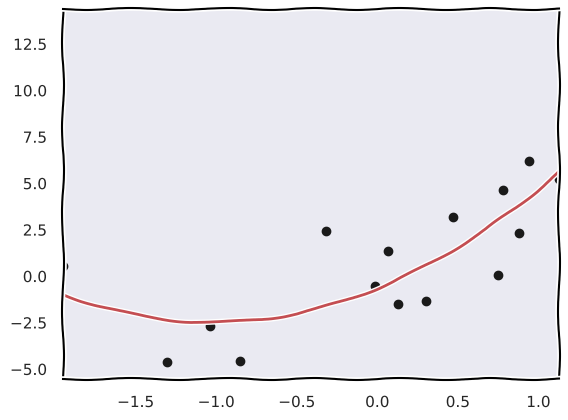

In [9]:
with plt.xkcd():
    plt.rcParams['font.family'] = 'DejaVu Sans' # to get rid of xkcd font warnings
    
    fig, ax = plt.subplots()
    ax.scatter(age, y, c='k')
    
    xs = np.linspace(-2, 2, 100)
    
    X = pd.DataFrame({f'x^{i}': age**i for i in range(3)})
    results = sm.OLS(y, X).fit()
    ax.plot(xs, results.predict(pd.DataFrame({f'x^{i}': xs**i for i in range(3)})), 'r')
    
    ax.set_xlim([age.min(), age.max()]);

**(e)** For $\lambda = 0, m = 3$, the penalty term vanishes so we only need to minimize the RSS term, which can be done using any interpolating function that connects the data points.

We'll just connect them by straight lines since that's the simplest way.

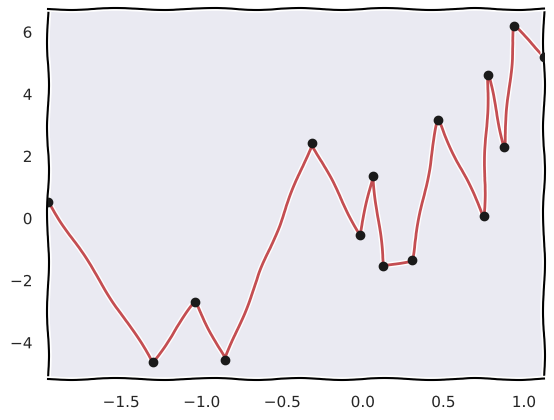

In [10]:
with plt.xkcd():
    plt.rcParams['font.family'] = 'DejaVu Sans' # to get rid of xkcd font warnings
    fig, ax = plt.subplots()
    ax.scatter(age, y, c='k', zorder=np.infty)
    
    sorted_indices = np.argsort(age)
    x_sorted = age[sorted_indices]
    y_sorted = y[sorted_indices]
    
    ax.plot(x_sorted, y_sorted, 'r')
    ax.set_xlim([age.min(), age.max()]);

### **Q3.**

For $X \ge 1$:

$$
\begin{align*}
Y &= 1 + X + -2 (X-1)^2  \\
 &= 1 + X + -2 X^2 +4X -2 \\
 &= -1 +5X -2X^2
\end{align*}
$$


For both cases:

$$
Y = 
\begin{cases}
-1 +5X -2X^2 , & \text{if } X \ge 1\\
1 + X , & \text{if } X \lt 1
\end{cases}
$$

We can see that for $X \ge 1$ the estimated curve is quadratic pointing down with an intercept of $-1$.
$$
\beta_0 = -1 \quad \beta_1 = 5 \quad \beta_2 = -2
$$

And for $X \lt 1$ the estimated curve is linear with an intercept and coefficient of $1$.
$$
\beta_0 = 1 \quad \beta_1 = 1
$$

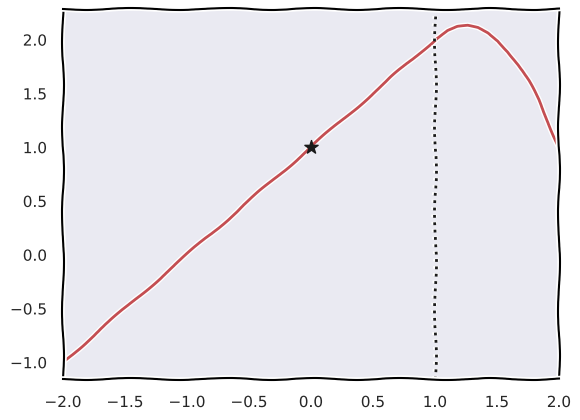

In [11]:
def func(x):
    if x >= 1:
        return 1 + x + -2 * (x - 1)**2
    else:
        return 1 + x
    
age = np.linspace(-2, 2)
y = np.vectorize(func)(age)

with plt.xkcd():
    plt.rcParams['font.family'] = 'DejaVu Sans' # to get rid of xkcd font warnings
    fig, ax = plt.subplots()
    
    ax.plot(age, y, 'r')
    ax.axvline(1, c='k', ls=':')
    ax.set_xlim([age.min(), age.max()]);
    
    ax.scatter(0, 1, c='k', marker='*', s=100, zorder=np.infty)

### **Q4.**


Expanding the basis functions we end up with the function below:
$$
Y = 
\begin{cases}
\beta_0, & \text{if } X \lt 0\\
\beta_0 + \beta_1, & \text{if } 0 \le X \le 2\\
\beta_0 + 2\beta_1 -\beta_1 X, & \text{if } 1 \lt X \le 2\\
\beta_0 , & \text{if } 2 \lt X \lt 3\\
\beta_0 - 3 \beta_2 + \beta_2 X, & \text{if } 3 \le X \le 4\\
\beta_0 + \beta_2, & \text{if } 4 \lt X \le 5\\
\beta_0, & \text{if } X \gt 5\\
\end{cases}
$$

Now we'll create the two basis functions.
$$
\begin{aligned}
b_{1}(X) &= I(0 \le X < 2)\;-\;(X - 1)\,I(1 \le X < 2),\\[6pt]
b_{2}(X) &= (X - 3)\,I(3 \le X < 4)\;+\;I(4 \le X < 5).
\end{aligned}
$$

In [12]:
def b1(x):
    """
    b1(x) = I(0 <= x < 2) - (x - 1) I(1 <= x < 2)
    """
    term1 = ((x >= 0) & (x < 2)).astype(float)    
    term2 = (x - 1) * ((x >= 1) & (x < 2)).astype(float)
    
    return term1 - term2

def b2(x):
    """
    b2(x) = (x - 3) I(3 <= x < 4) + I(4 <= x < 5)
    """
    term1 = (x - 3) * ((x >= 3) & (x < 4)).astype(float)
    term2 = ((x >= 4) & (x < 5)).astype(float)
    
    return term1 + term2

Using the coefficient estimates:
$$
\hat Y = 1 + 1 b_1(x) + 3 b_2(x)
$$

We'll sketch this function for values between $-2$ and $6$.

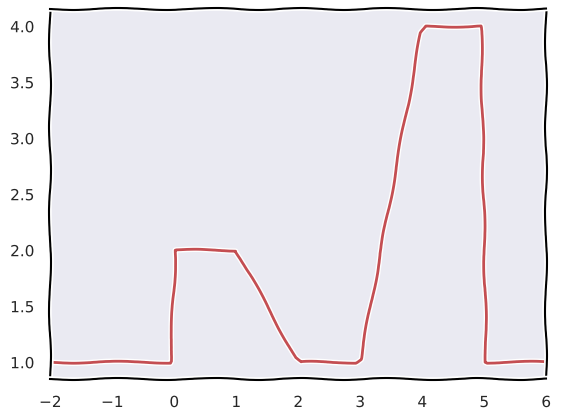

In [13]:
age = np.linspace(-2, 6, 100)
y = 1 + 1 * b1(age) + 3 * b2(age)

with plt.xkcd():
    plt.rcParams['font.family'] = 'DejaVu Sans' # to get rid of xkcd font warnings
    fig, ax = plt.subplots()
    
    ax.plot(age, y, 'r')
    ax.set_xlim([age.min(), age.max()]);

The estimated curve is split into multiple regions some are constant and some are linear according to the following function.
$$
\hat Y = 
\begin{cases}
1, & \text{if } X \lt 0\\
2, & \text{if } 0 \le X \le 2\\
3 - X, & \text{if } 1 \lt X \le 2\\
1 , & \text{if } 2 \lt X \lt 3\\
- 8 + 3 X, & \text{if } 3 \le X \le 4\\
4, & \text{if } 4 \lt X \le 5\\
1, & \text{if } X \gt 5\\
\end{cases}
$$

One thing to note is that the function is continous in the region $0 \lt X \lt 5$, and breaks at the boundaries.

The slopes and intercepts for each region are apparent in the function above.

### **Q5.**

**(a)** $\hat g_2$ will have a smaller training RSS since it's a cubic model which is more flexible than the quadratic model you'd get from $\hat g_1$.

**(b)** This depends on the nature of the true underlying model from which the data is generated, if it's closer to a quadratic model $\hat g_1$ will have the smaller RSS, if it's cubic or more flexible than a cubic $\hat g_2$ will have the smaller RSS.

**(c)** Both would have a training RSS of $0$ since they'd have to interpolate the data points. However there are infinitely many possible functions that interpolate the training set which means the test RSS depends on how the interpolating function is chosen. If both $\hat g_1$ and $\hat g_2$ are chosen according to the same method then their test RSS would also be the same.

## Applied


### **Q6.**

In [14]:
wage = load_data('Wage')
wage.head()

year  age            maritl      race        education              region  \
0  2006   18  1. Never Married  1. White     1. < HS Grad  2. Middle Atlantic   
1  2004   24  1. Never Married  1. White  4. College Grad  2. Middle Atlantic   
2  2003   45        2. Married  1. White  3. Some College  2. Middle Atlantic   
3  2003   43        2. Married  3. Asian  4. College Grad  2. Middle Atlantic   
4  2005   50       4. Divorced  1. White       2. HS Grad  2. Middle Atlantic   

         jobclass          health health_ins   logwage        wage  
0   1. Industrial       1. <=Good      2. No  4.318063   75.043154  
1  2. Information  2. >=Very Good      2. No  4.255273   70.476020  
2   1. Industrial       1. <=Good     1. Yes  4.875061  130.982177  
3  2. Information  2. >=Very Good     1. Yes  5.041393  154.685293  
4  2. Information       1. <=Good     1. Yes  4.318063   75.043154

In [15]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        3000 non-null   int64   
 1   age         3000 non-null   int64   
 2   maritl      3000 non-null   category
 3   race        3000 non-null   category
 4   education   3000 non-null   category
 5   region      3000 non-null   category
 6   jobclass    3000 non-null   category
 7   health      3000 non-null   category
 8   health_ins  3000 non-null   category
 9   logwage     3000 non-null   float64 
 10  wage        3000 non-null   float64 
dtypes: category(7), float64(2), int64(2)
memory usage: 115.5 KB


In [16]:
wage.describe(include='number')

year          age      logwage         wage
count  3000.000000  3000.000000  3000.000000  3000.000000
mean   2005.791000    42.414667     4.653905   111.703608
std       2.026167    11.542406     0.351753    41.728595
min    2003.000000    18.000000     3.000000    20.085537
25%    2004.000000    33.750000     4.447158    85.383940
50%    2006.000000    42.000000     4.653213   104.921507
75%    2008.000000    51.000000     4.857332   128.680488
max    2009.000000    80.000000     5.763128   318.342430

In [17]:
wage.describe(include='category')

maritl      race   education              region       jobclass  \
count         3000      3000        3000                3000           3000   
unique           5         4           5                   1              2   
top     2. Married  1. White  2. HS Grad  2. Middle Atlantic  1. Industrial   
freq          2074      2480         971                3000           1544   

                health health_ins  
count             3000       3000  
unique               2          2  
top     2. >=Very Good     1. Yes  
freq              2142       2083

In [18]:
age = wage['age']
y = wage['wage']

kfold = skm.KFold(5, shuffle=True, random_state=1)

params = {"poly__degree": np.arange(1, 20)}

polyPipe = Pipeline([("poly", PolynomialFeatures()),
                     ("linreg", skl.LinearRegression())])

cv_results = skm.GridSearchCV(polyPipe, param_grid=params, cv=kfold).fit(np.reshape(age, (-1, 1)), y)
cv_results

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('linreg', LinearRegression())]),
             param_grid={'poly__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [19]:
best_degree = cv_results.best_params_['poly__degree']
best_degree

7

The optimal degree for the polynomial chosen by cross-validation is $7$.

In [20]:
models = [MS([poly('age', degree=d)]) 
          for d in range(1, best_degree+1)]
Xs = [model.fit_transform(wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])

df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.692606  2.253516e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.895608  1.672982e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.812453  5.096592e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.805534  3.695162e-01
5    2993.0  4.766389e+06      1.0    3932.257665    2.469715  1.161646e-01
6    2992.0  4.763834e+06      1.0    2555.281281    1.604884  2.053110e-01

Which is different from the best degree we'd pick by following the ANOVA results $(5)$.

In [21]:
bestPoly = cv_results.best_estimator_
bestPoly

Pipeline(steps=[('poly', PolynomialFeatures(degree=7)),
                ('linreg', LinearRegression())])

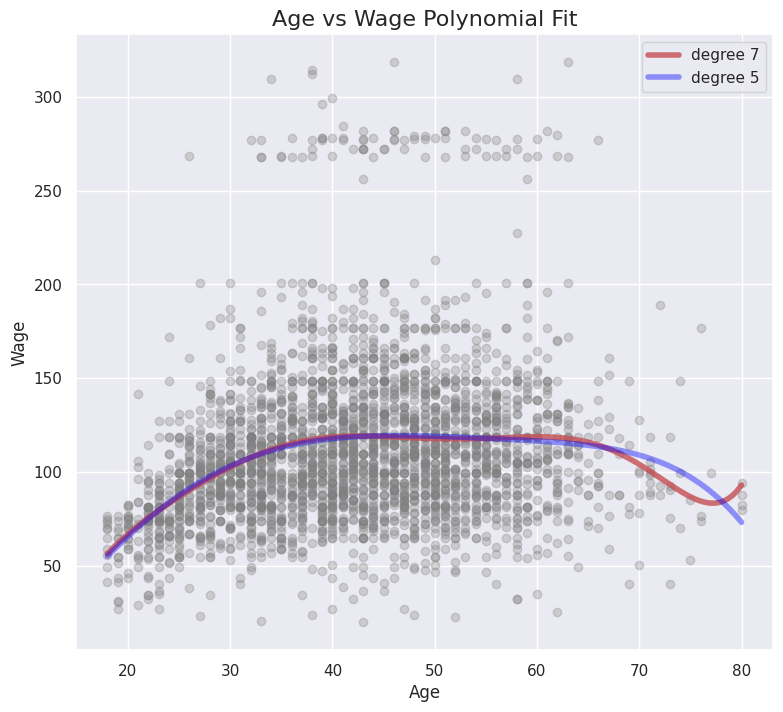

In [22]:

fig, ax = plt.subplots(figsize=(9,8))
ax.scatter(age, y, alpha=0.3, c='gray')

# plotting the 7 degree polynomial
xs = np.linspace(age.min(), age.max(), 1000).reshape((-1, 1))
ax.plot(xs, bestPoly.predict(xs), lw=4, c='r', alpha=0.8, label='degree 7')

# fitting and plotting the 5 degree polynomial
polyPipe5 = Pipeline([("poly", PolynomialFeatures(5)),
                     ("linreg", skl.LinearRegression())]).fit(np.reshape(age,(-1,1)), y)

ax.plot(xs, polyPipe5.predict(xs), lw=4, c='blue', alpha=0.4, label='degree 5')


ax.set_title('Age vs Wage Polynomial Fit', fontsize=16)
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.legend();

**(b)** 

In [23]:
pipeCut = Pipeline([
    ('discretizer', KBinsDiscretizer(encode='onehot-dense', strategy='uniform')),
    ('linreg', skl.LinearRegression())
])

param_grid = {
    'discretizer__n_bins': np.arange(2, 21)  # trying from 2 to 20 bins (1 to 19 cuts)
}

cv_results = skm.GridSearchCV(pipeCut, param_grid, cv=kfold).fit(np.reshape(age, (-1, 1)), y)
cv_results.best_params_

{'discretizer__n_bins': 16}

In [24]:
best_estimator = cv_results.best_estimator_
best_estimator

Pipeline(steps=[('discretizer',
                 KBinsDiscretizer(encode='onehot-dense', n_bins=16,
                                  strategy='uniform')),
                ('linreg', LinearRegression())])

In [25]:
best_cut = cv_results.best_params_['discretizer__n_bins']
best_cut

16

The optimal number of bins chosen by cross-validation is $16$ ($15$ cuts).

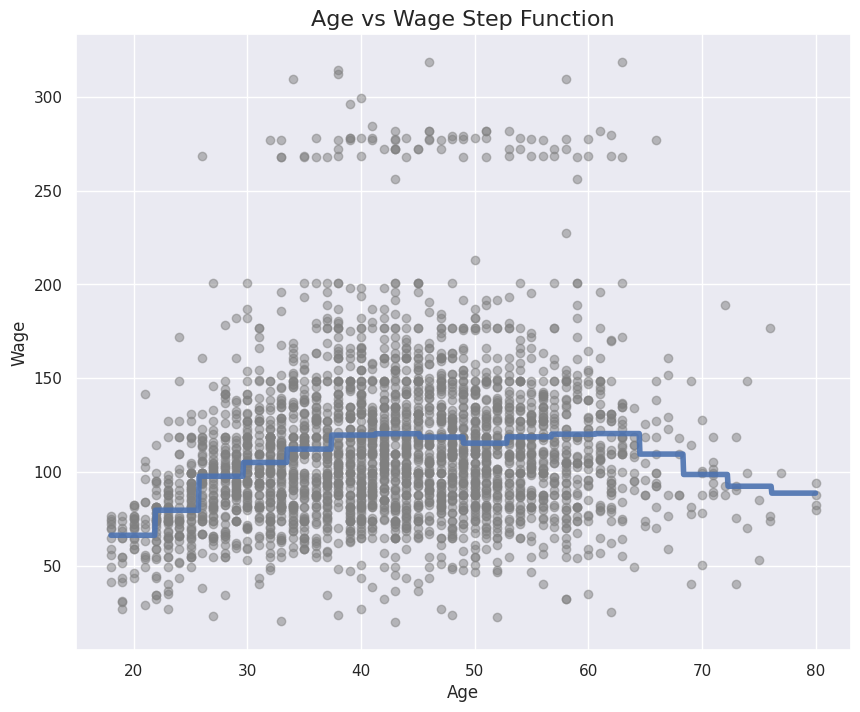

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)

new_age = np.linspace(age.min(), age.max(), 1000).reshape(-1, 1)
ax.plot(new_age, best_estimator.predict(new_age), 'b-', linewidth=4, alpha=0.9)

ax.set_title('Age vs Wage Step Function', fontsize=16)
ax.set_xlabel('Age')
ax.set_ylabel('Wage');

### **Q7.** 

We'll create some plots of the quantitative variables first to understand them better.

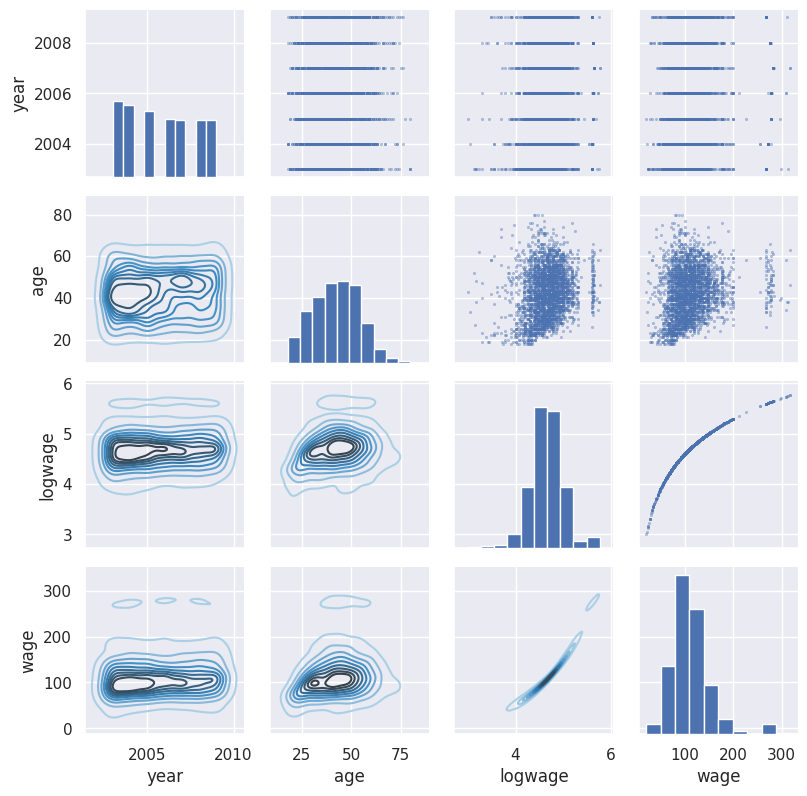

In [27]:
g = sns.PairGrid(wage)
g.map_upper(plt.scatter, s=3, linewidths=0.4, alpha=0.4)
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.figure.set_size_inches(8, 8)

Some boxen plots of the qualitative variables.

In [28]:
categorical_columns = wage.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['maritl', 'race', 'education', 'region', 'jobclass', 'health',
       'health_ins'],
      dtype='object')

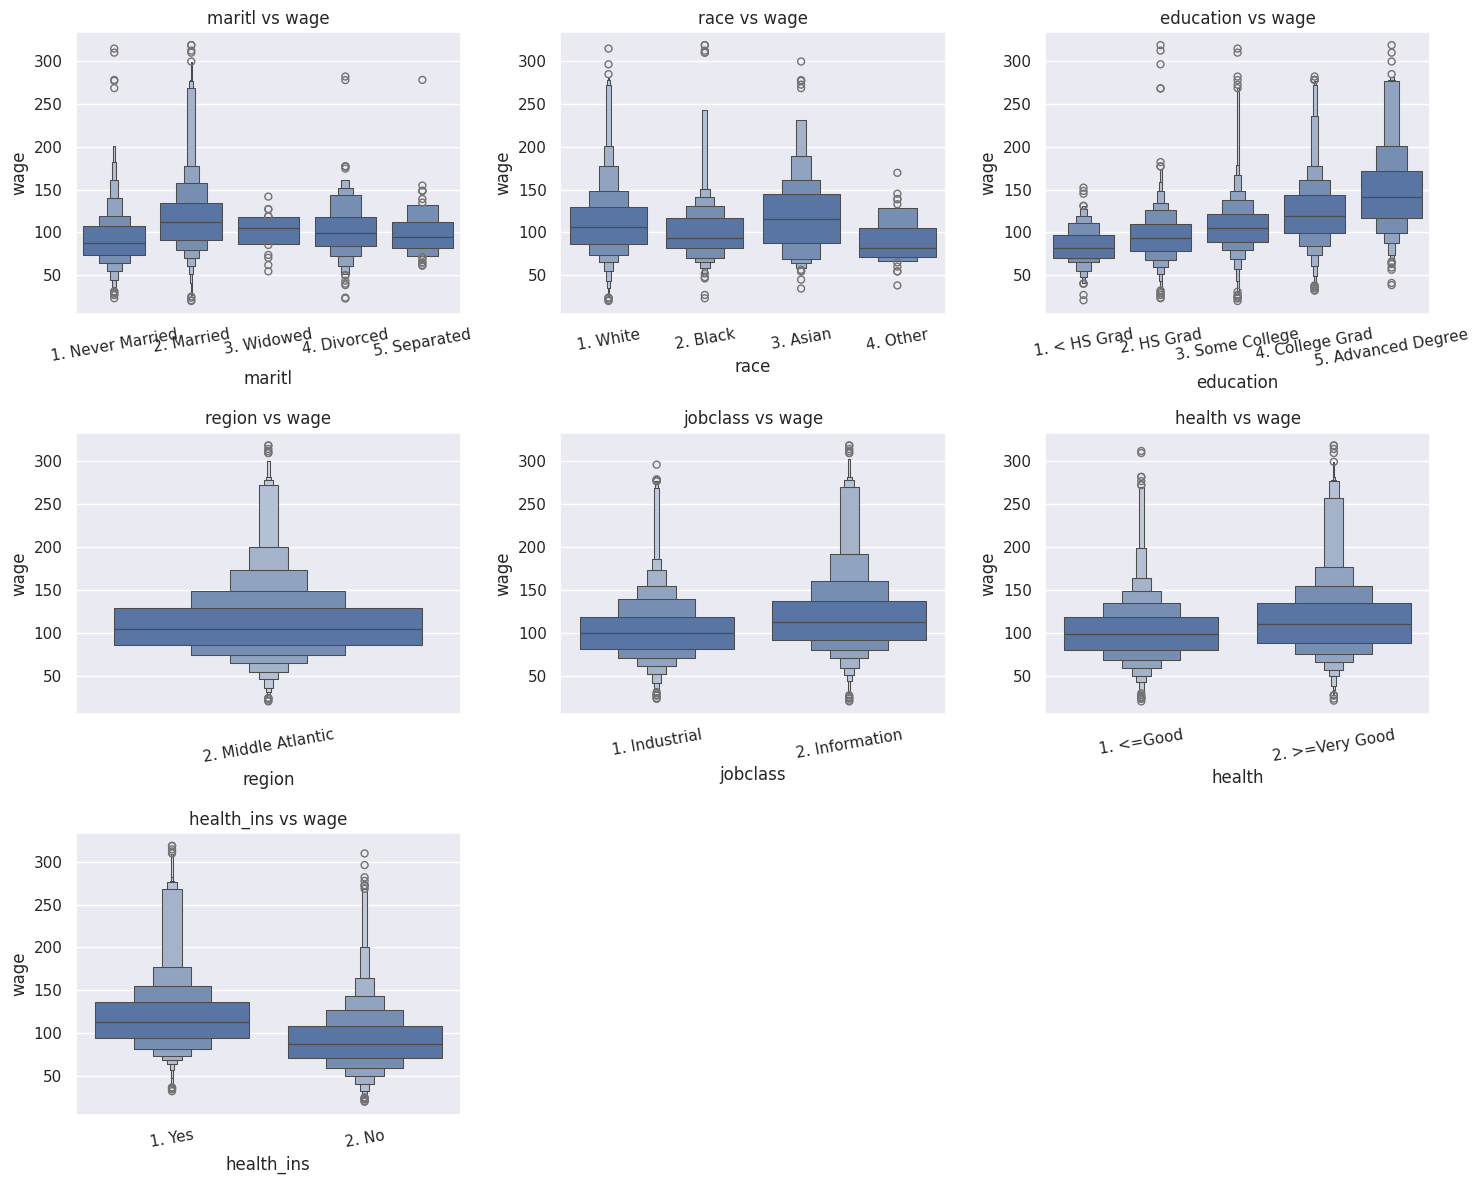

In [29]:
n_cols = 3
n_rows = math.ceil(len(categorical_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), squeeze=False)
axes = axes.flatten()

for idx, col in enumerate(categorical_columns):
    sns.boxenplot(x=col, y='wage', data=wage, ax=axes[idx])
    axes[idx].set_title(f'{col} vs wage')
    axes[idx].tick_params(axis='x', labelrotation=10)
    axes[idx].tick_params(axis='y')

# If there are empty subplots, hide them
total_plots = n_rows * n_cols
for idx in range(len(categorical_columns), total_plots):
    axes[idx].set_visible(False)

plt.tight_layout()

In [30]:
def fit_gam(columns: list, df: pd.DataFrame) -> LinearGAM:
    """ 
    A simple function that fits gam models using factor terms with lam=0 for categorical variables
    and spline terms with default lam=0.6 for numerical variables.
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    gam_terms = [f_gam(i, lam=0) if col in cat_cols else s_gam(i) for i, col in enumerate(columns)]
    X_terms = [df[col].cat.codes if col in cat_cols else df[col] for col in columns]
    
    gam = LinearGAM(np.sum(gam_terms))
    Xgam = np.column_stack(X_terms)
    return gam.fit(Xgam, y)


def plot_gam_terms(gam, columns: list, df:pd.DataFrame, y_name:str):
    """
    A simple function that plots partial gam plots on one figure
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    n_plots = len(columns)
    n_rows = math.ceil(n_plots/3)
    n_cols = math.ceil(n_plots/n_rows)
    
    _, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]
        
        plot_gam(gam, i, ax=ax)
        
        ax.set_xlabel(col)         
        ax.set_ylabel(f'Effect on {y_name}')
        ax.set_title(f'Partial dependence of {col} on {y_name}')
        
        if col in cat_cols:
            ax.set_xticklabels(df[col].cat.categories)
            ax.tick_params(axis='x', labelrotation=23)
            
    plt.tight_layout()

Now I'll fit a bunch of GAM models using the functions defined above using different combinations of the columns 

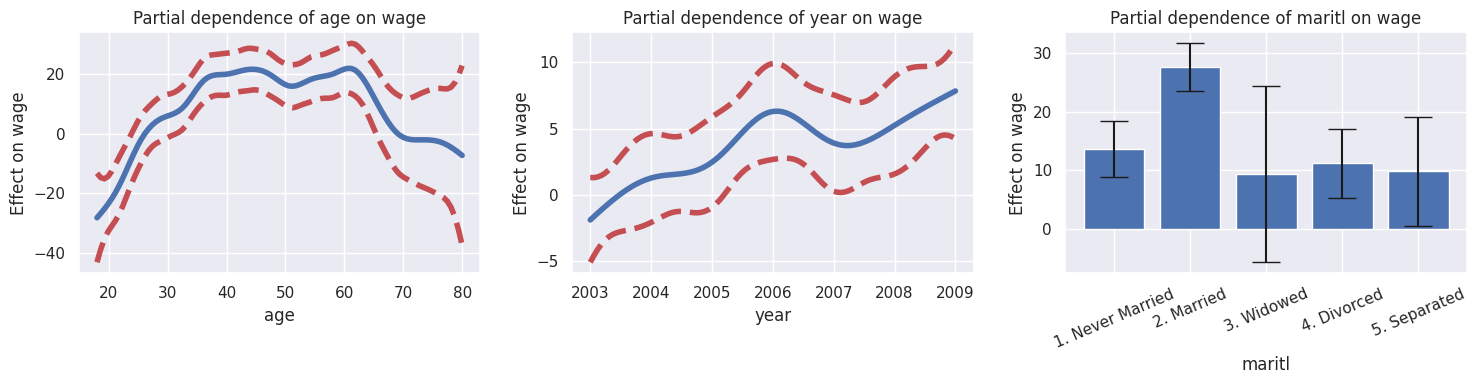

In [31]:
cols = ['age', 'year', 'maritl']
gam_maritl = fit_gam(cols, wage)
plot_gam_terms(gam_maritl, cols, wage, 'wage')

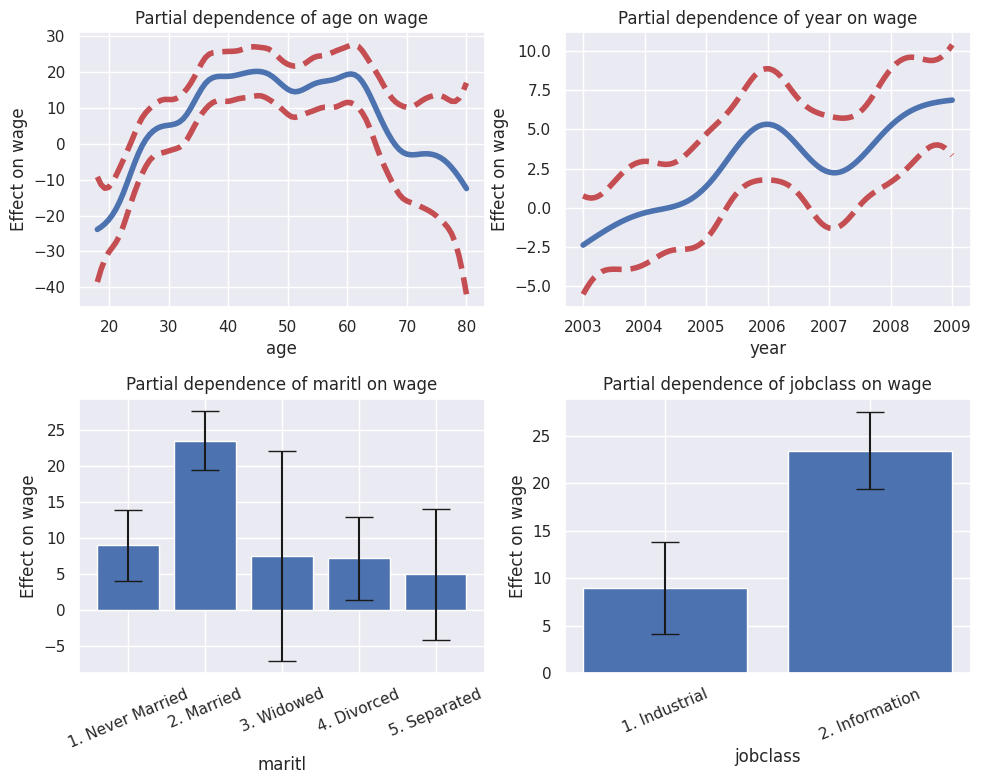

In [32]:
cols = ['age', 'year', 'maritl', 'jobclass']
gam_maritl_job = fit_gam(cols, wage)
plot_gam_terms(gam_maritl_job, cols, wage, 'wage')

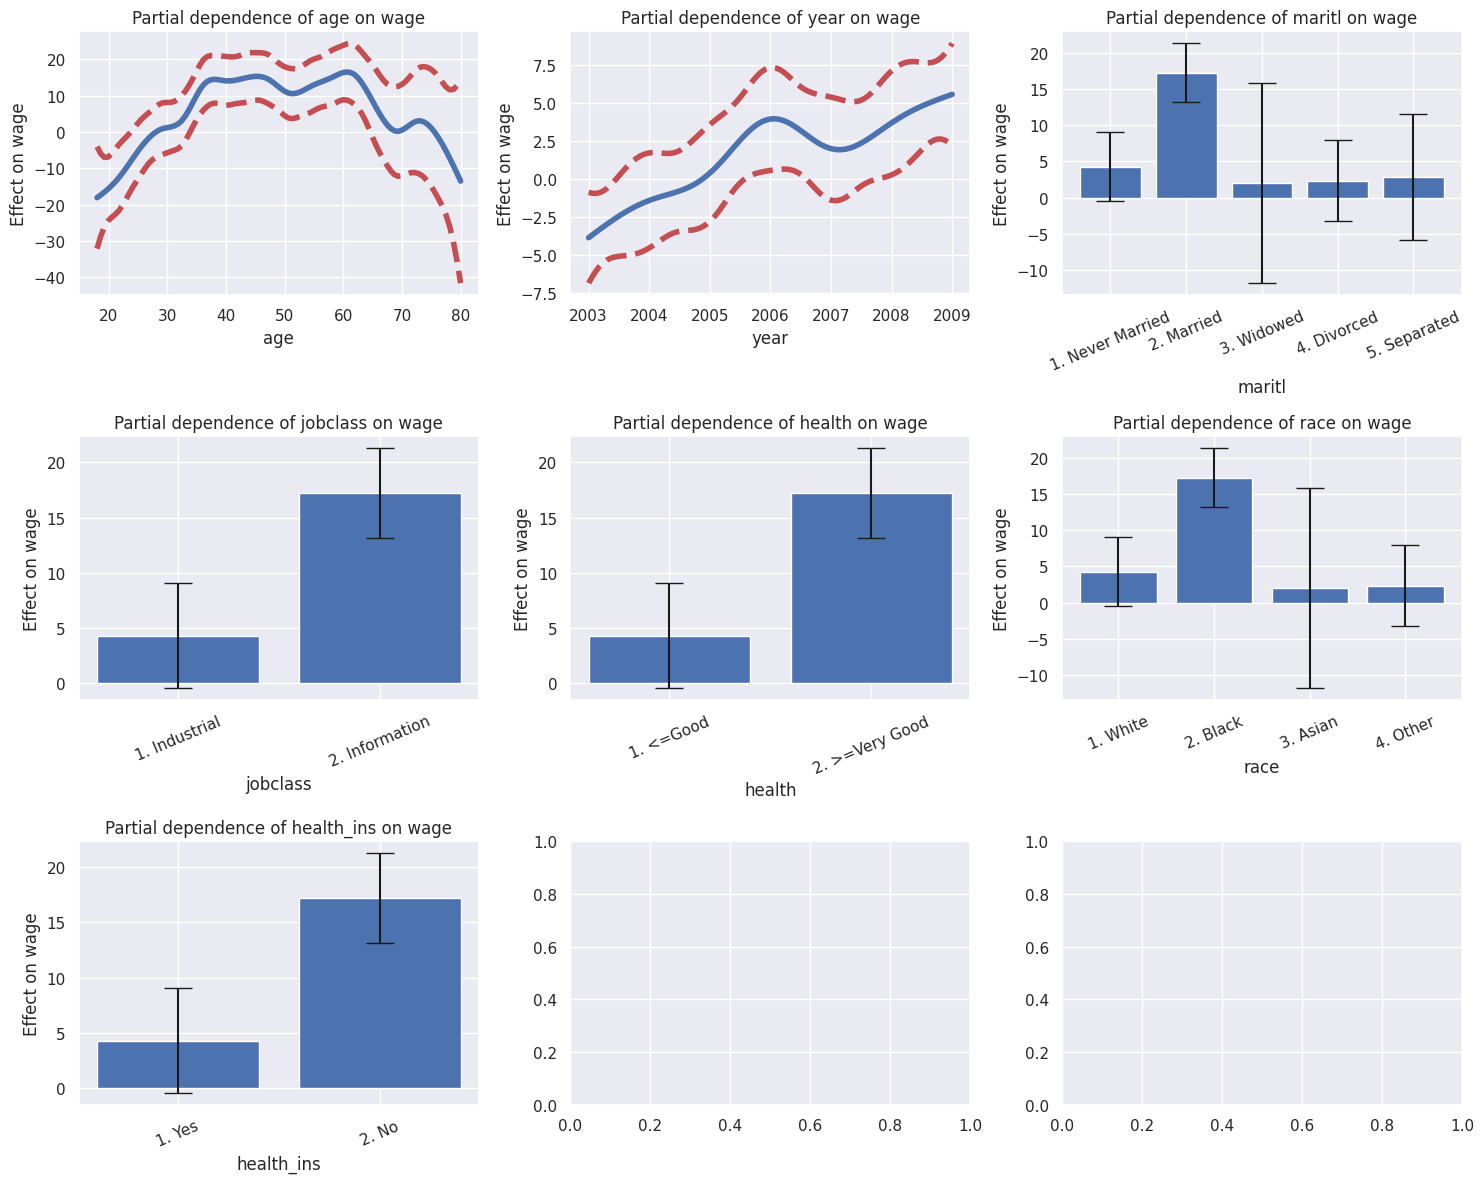

In [33]:
cols = ['age', 'year', 'maritl', 'jobclass', 'health', 'race', 'health_ins']
gam_full = fit_gam(cols, wage)
plot_gam_terms(gam_full, cols, wage, 'wage')

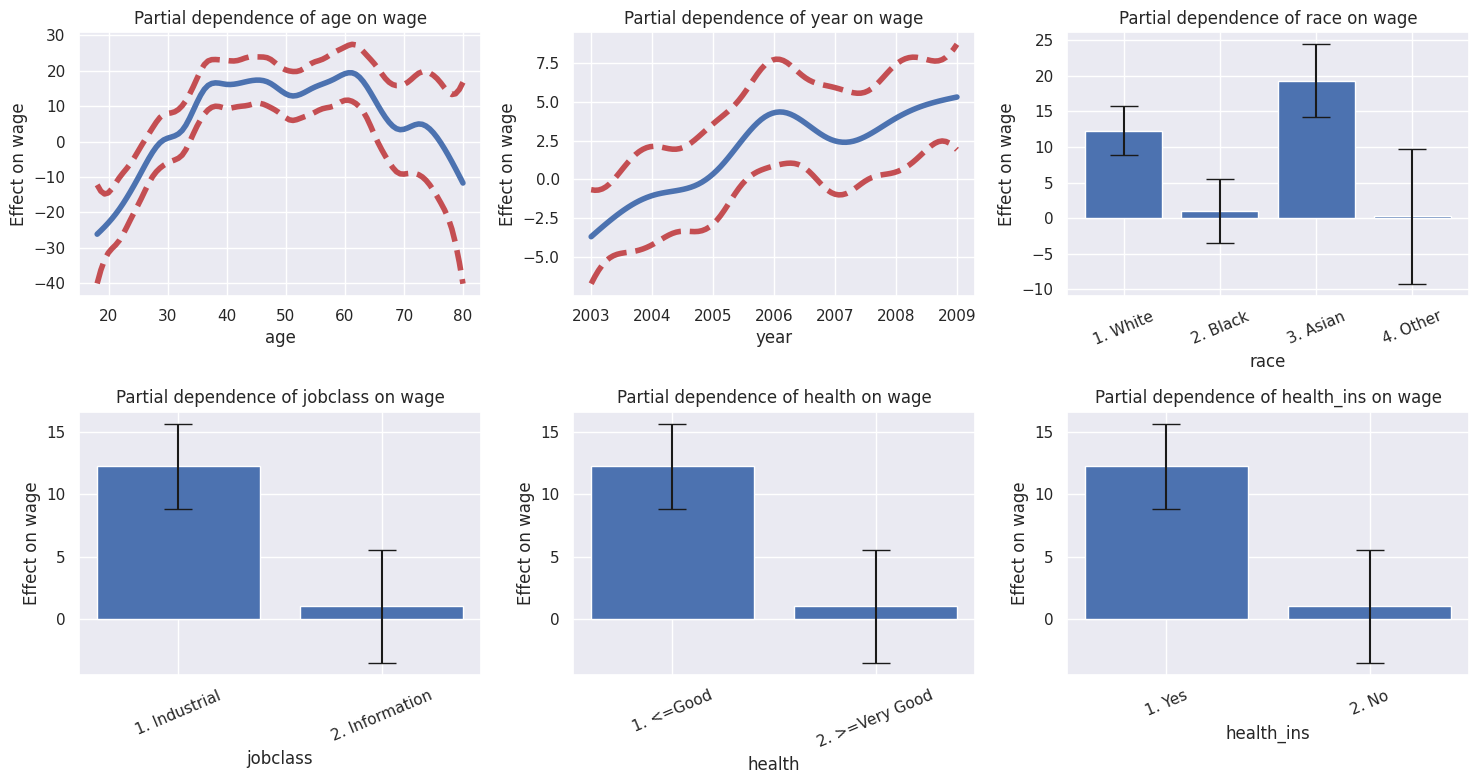

In [34]:
cols = ['age', 'year', 'race', 'jobclass', 'health', 'health_ins']
gam_no_maritl = fit_gam(cols, wage)
plot_gam_terms(gam_no_maritl, cols, wage, 'wage')

Removing the the `maritl` term significantly affected the other coefficients.

We'll do a quick ANOVA test on the 3 models we fitted earlier.

Note: `anova_gam` assumes the models are nested, as in the predictors in the first model have to be a subset of the predictors in the second model and so on.

In [35]:
anova_gam(gam_maritl, gam_maritl_job, gam_full)

deviance           df  deviance_diff   df_diff           F  \
0  4.602715e+06  2974.804326            NaN       NaN         NaN   
1  4.430372e+06  2973.804621  172343.496485  0.999705  126.804962   
2  4.036164e+06  2968.807511  394207.280901  4.997110   58.025501   

         pvalue  
0           NaN  
1  1.615249e-12  
2  7.221814e-15

In [36]:
anova_gam(gam_no_maritl, gam_full)

deviance           df  deviance_diff   df_diff         F        pvalue
0  4.133688e+06  2972.804219            NaN       NaN       NaN           NaN
1  4.036164e+06  2968.807511   97523.743223  3.996708  17.94821  9.697761e-08

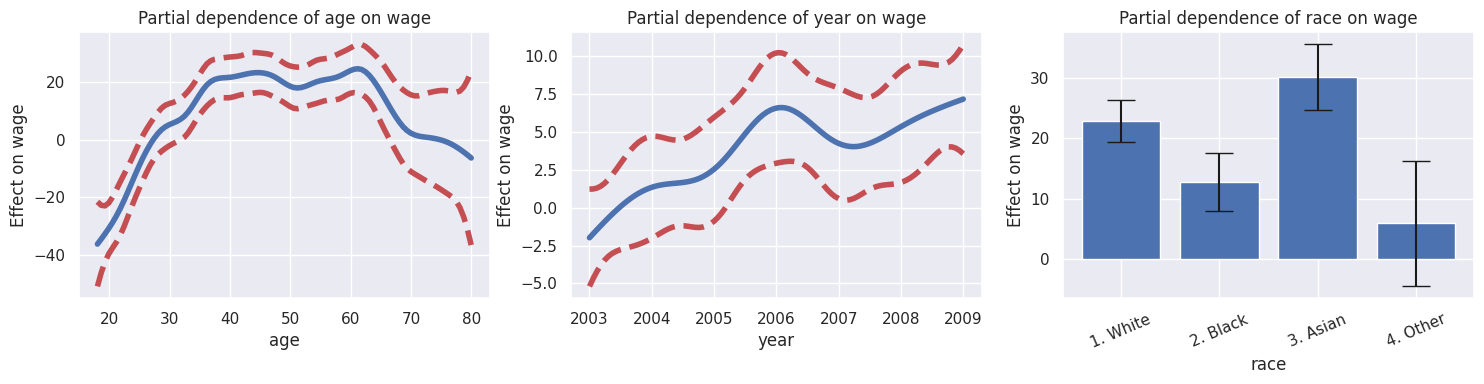

In [37]:
cols = ['age', 'year', 'race']
gam_race = fit_gam(cols, wage)
plot_gam_terms(gam_race, cols, wage, 'wage')

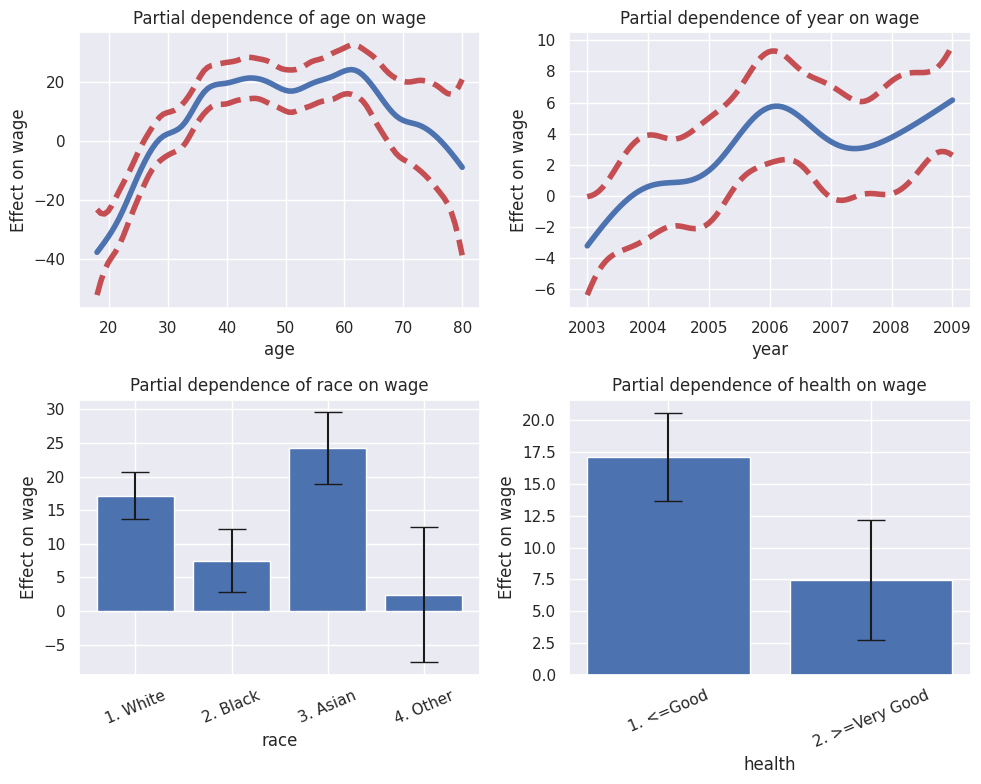

In [38]:
cols = ['age', 'year', 'race', 'health']
gam_health_race = fit_gam(cols, wage)
plot_gam_terms(gam_health_race, cols, wage, 'wage')

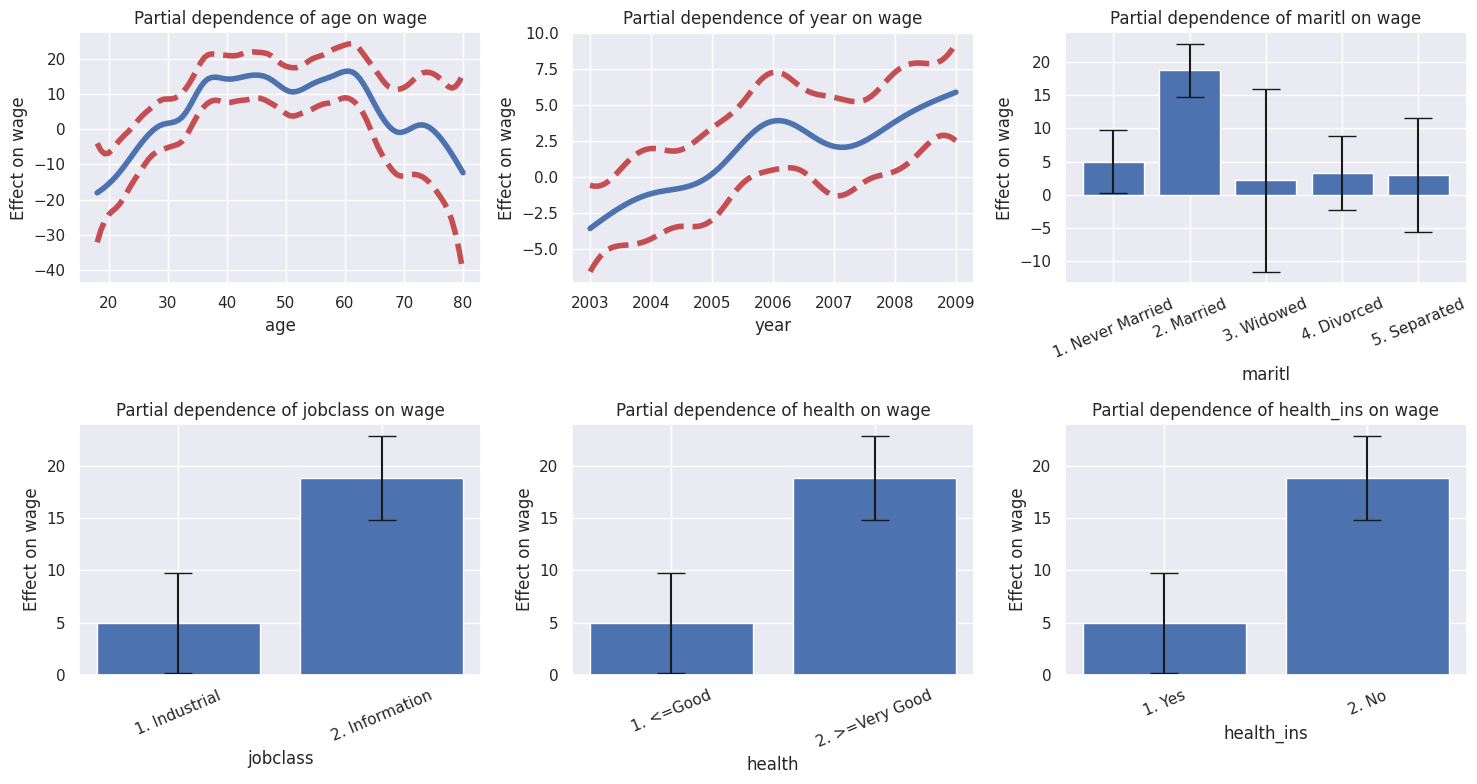

In [39]:
cols = ['age', 'year', 'maritl', 'jobclass', 'health', 'health_ins']
gam_no_race = fit_gam(cols, wage)
plot_gam_terms(gam_no_race, cols, wage, 'wage')

Comparing with the plot of `gam_full` from earlier we can see not much changed after removing the `race` predictor, this could indicate that most of the variance in `wage` is explained by the `maritl` predictor.

Another quick ANOVA test shows that while it's not noticable in the plot the difference between the models is statistically significant.

In [40]:
anova_gam(gam_race, gam_health_race, gam_full)

deviance           df  deviance_diff   df_diff           F  \
0  4.676232e+06  2975.802852            NaN       NaN         NaN   
1  4.538308e+06  2974.803262  137924.517292  0.999590  101.492259   
2  4.036164e+06  2968.807511  502143.594980  5.995751   61.602383   

         pvalue  
0           NaN  
1  2.517522e-11  
2  6.406628e-16

In [41]:
anova_gam(gam_no_race, gam_full)

deviance           df  deviance_diff   df_diff         F    pvalue
0  4.070757e+06  2971.805679            NaN       NaN       NaN       NaN
1  4.036164e+06  2968.807511   34593.144492  2.998168  8.486865  0.000288

### **Q8.**

In [42]:
auto = load_data('Auto')
auto.head()

mpg  cylinders  displacement  horsepower  weight  \
name                                                                           
chevrolet chevelle malibu  18.0          8         307.0         130    3504   
buick skylark 320          15.0          8         350.0         165    3693   
plymouth satellite         18.0          8         318.0         150    3436   
amc rebel sst              16.0          8         304.0         150    3433   
ford torino                17.0          8         302.0         140    3449   

                           acceleration  year  origin  
name                                                   
chevrolet chevelle malibu          12.0    70       1  
buick skylark 320                  11.5    70       1  
plymouth satellite                 11.0    70       1  
amc rebel sst                      12.0    70       1  
ford torino                        10.5    70       1

In [43]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 27.6+ KB


In [44]:
auto.describe()

mpg   cylinders  displacement  horsepower       weight  \
count  392.000000  392.000000    392.000000  392.000000   392.000000   
mean    23.445918    5.471939    194.411990  104.469388  2977.584184   
std      7.805007    1.705783    104.644004   38.491160   849.402560   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.000000    4.000000    105.000000   75.000000  2225.250000   
50%     22.750000    4.000000    151.000000   93.500000  2803.500000   
75%     29.000000    8.000000    275.750000  126.000000  3614.750000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       acceleration        year      origin  
count    392.000000  392.000000  392.000000  
mean      15.541327   75.979592    1.576531  
std        2.758864    3.683737    0.805518  
min        8.000000   70.000000    1.000000  
25%       13.775000   73.000000    1.000000  
50%       15.500000   76.000000    1.000000  
75%       17.025000   79.000000    2.000000  
max       24.800000   82.000000    3.000000

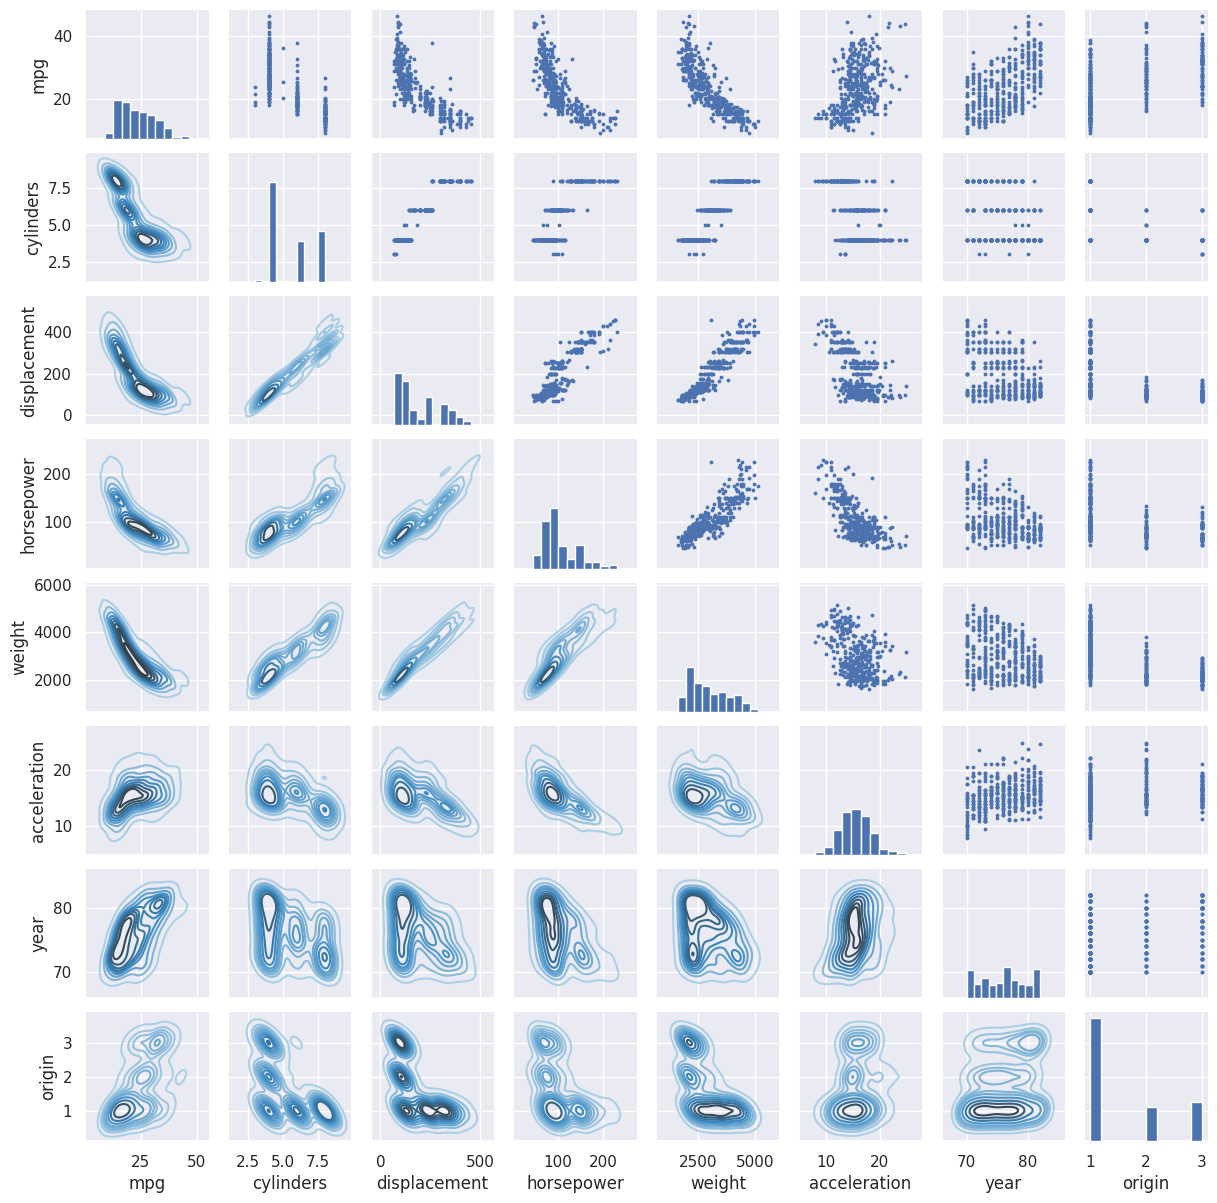

In [45]:
g = sns.PairGrid(auto)
g.map_upper(plt.scatter, s=3)
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.figure.set_size_inches(12, 12)

We can see some non-linear relationships for `mpg`.

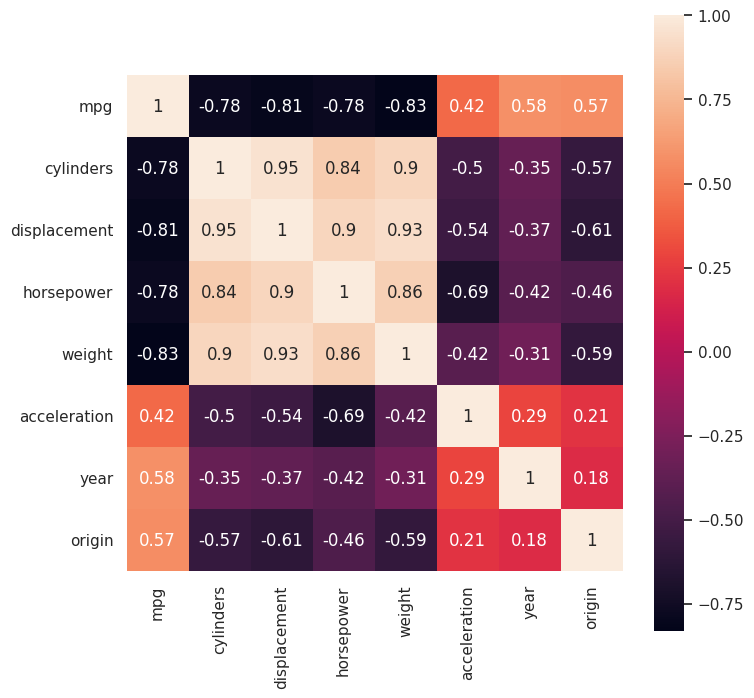

In [46]:
plt.figure().set_size_inches(8, 8)
sns.heatmap(auto.corr(), annot=True, square=True);

We'll use the function we made earlier to make some GAM fits and plots.

In [47]:
def fit_gam(columns: list, df: pd.DataFrame, response: str, s_lam=0.6) -> LinearGAM:
    """ 
    A simple function that fits gam models using factor terms with lam=0 for categorical variables
    and spline terms with default lam=0.6 for numerical variables.
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    gam_terms = [f_gam(i, lam=0) if col in cat_cols else s_gam(i, lam=s_lam) for i, col in enumerate(columns)]
    X_terms = [df[col].cat.codes if col in cat_cols else df[col] for col in columns]
    
    gam = LinearGAM(np.sum(gam_terms))
    Xgam = np.column_stack(X_terms)
    return gam.fit(Xgam, df[response])


def plot_gam_terms(gam, columns: list, df:pd.DataFrame, y_name:str):
    """
    A simple function that plots partial gam plots on one figure
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    n_plots = len(columns)
    n_rows = math.ceil(n_plots/3)
    n_cols = math.ceil(n_plots/n_rows)
    
    _, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]
        
        plot_gam(gam, i, ax=ax)
        
        ax.set_xlabel(col)         
        ax.set_ylabel(f'Effect on {y_name}')
        ax.set_title(f'Partial dependence of {col} on {y_name}')
        
        if col in cat_cols:
            ax.set_xticklabels(df[col].cat.categories)
            ax.tick_params(axis='x', labelrotation=23)
            
    plt.tight_layout()

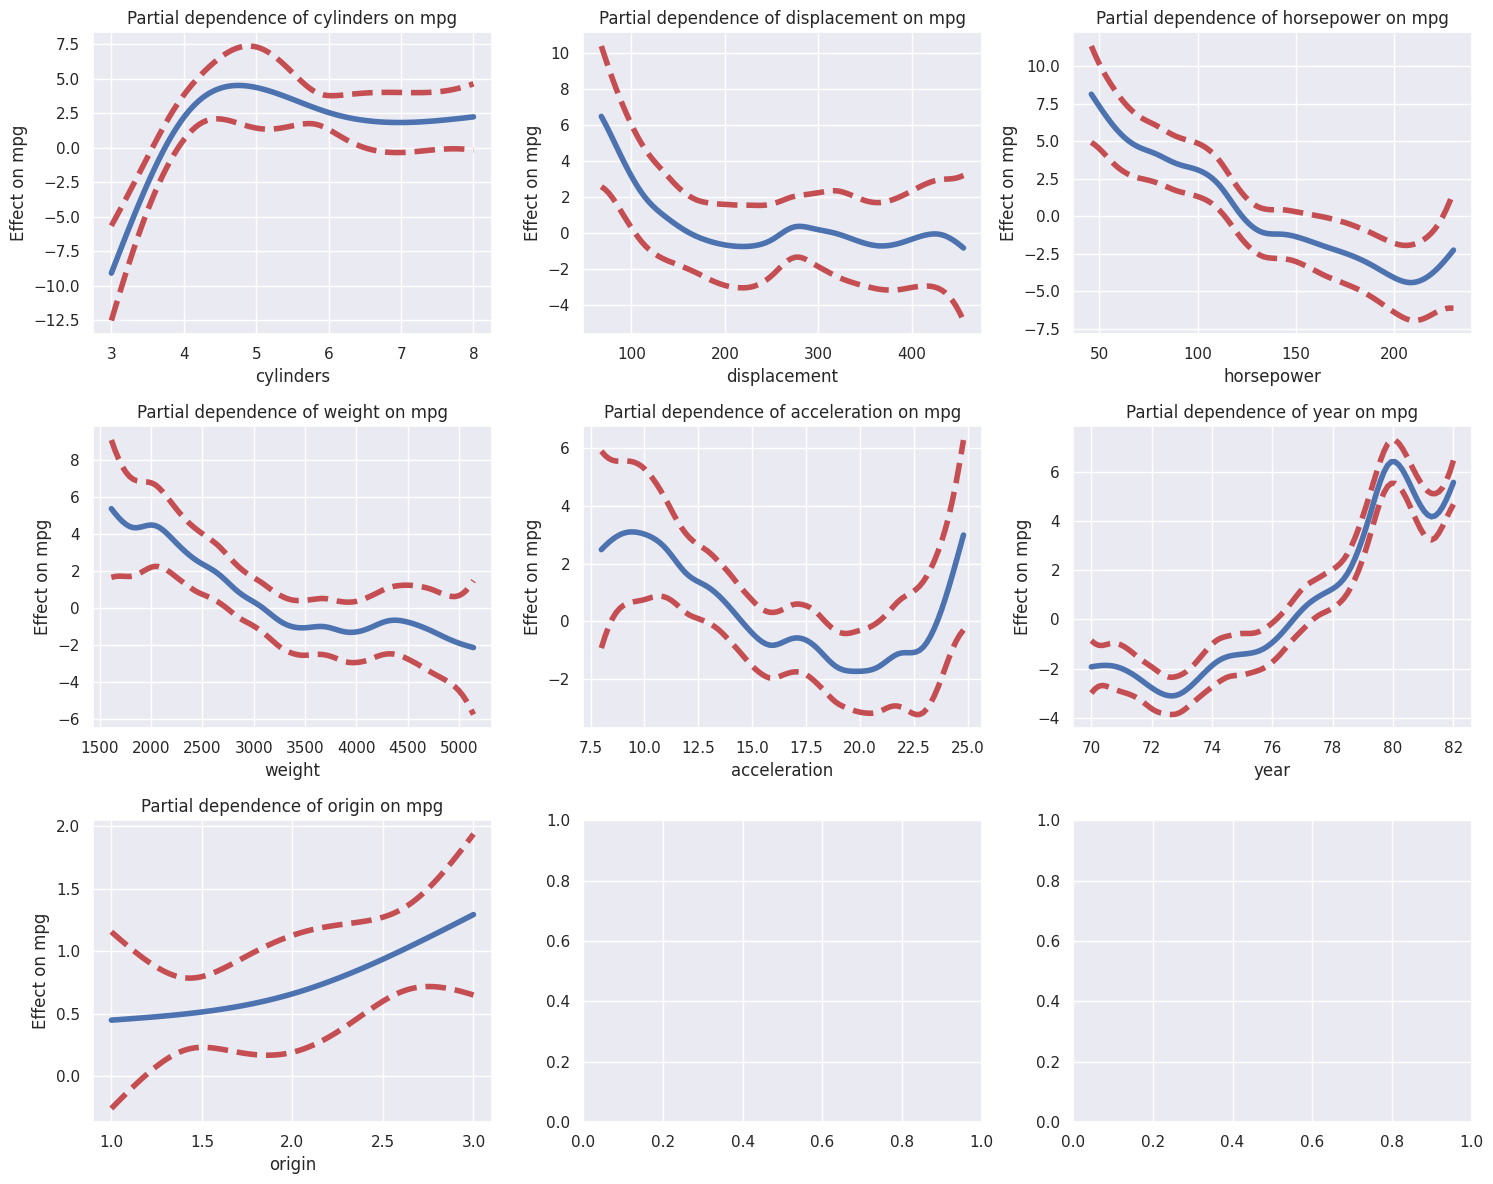

In [48]:
cols = auto.columns.drop('mpg')
gam = fit_gam(cols, auto, response='mpg')
plot_gam_terms(gam, cols, auto, 'mpg')

We'll increase the value of the penalty `lam` to get smoother fits.

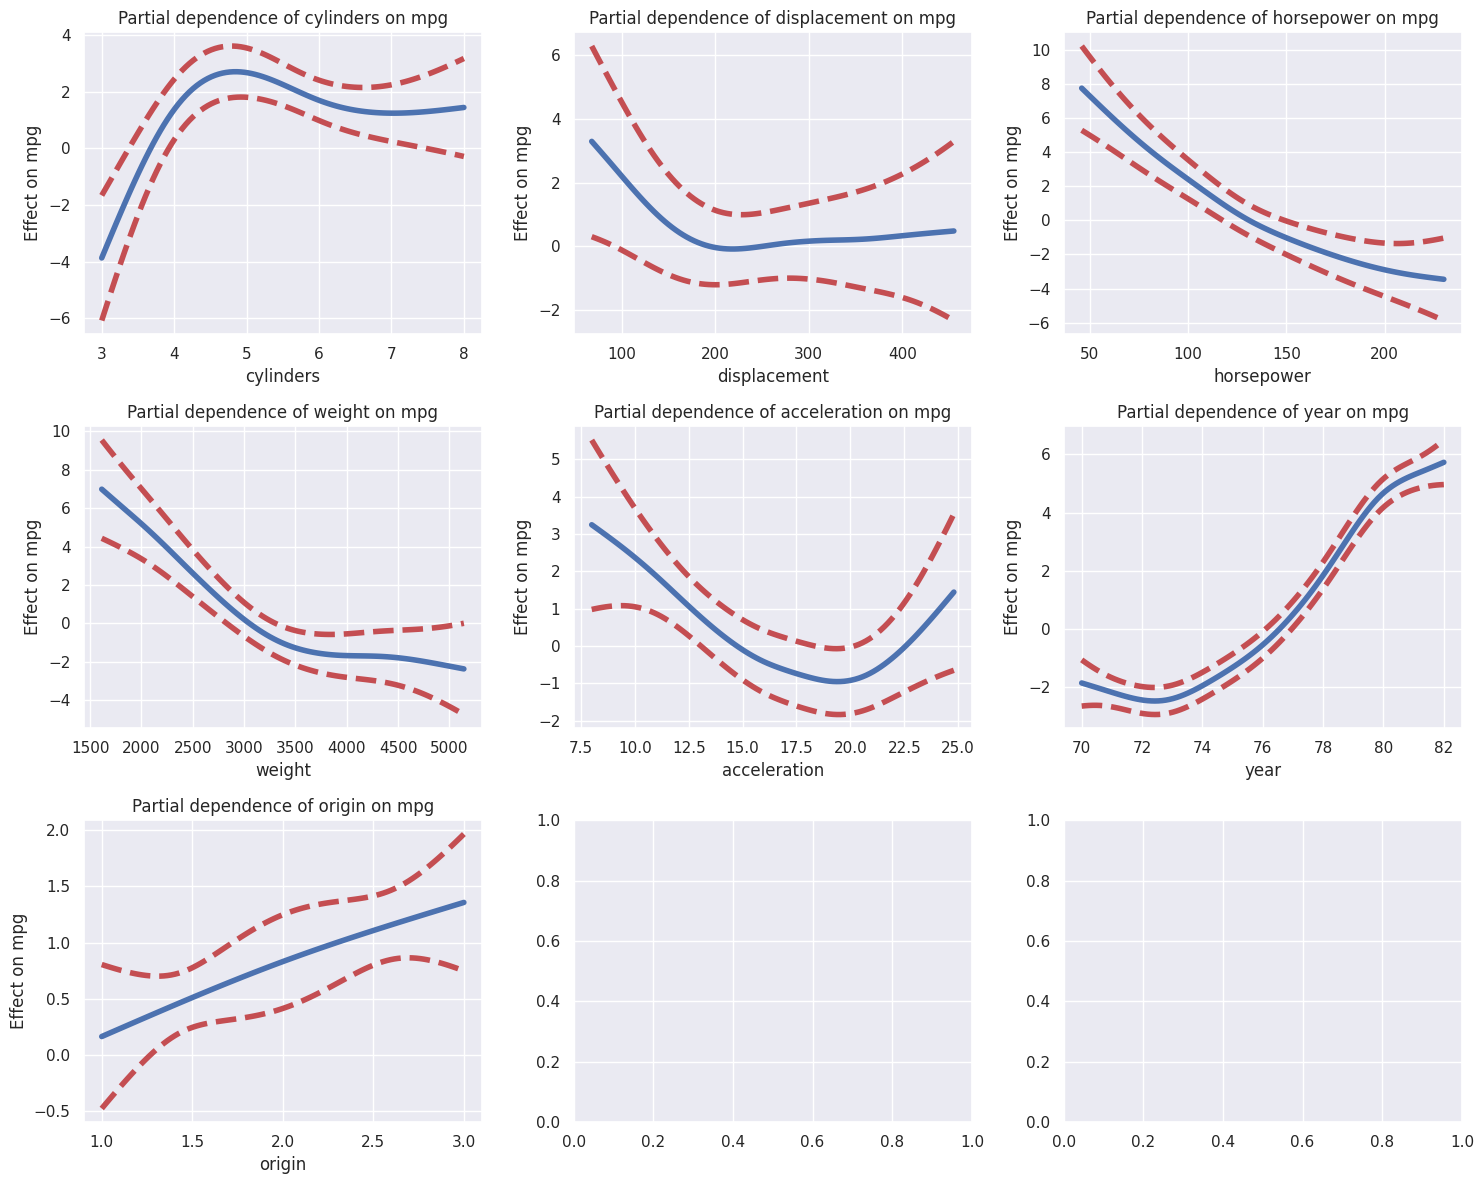

In [49]:
cols = auto.columns.drop('mpg')
gam = fit_gam(cols, auto, response='mpg', s_lam=70)
plot_gam_terms(gam, cols, auto, 'mpg')

We can try a local regression (lowess) fit on the data too.

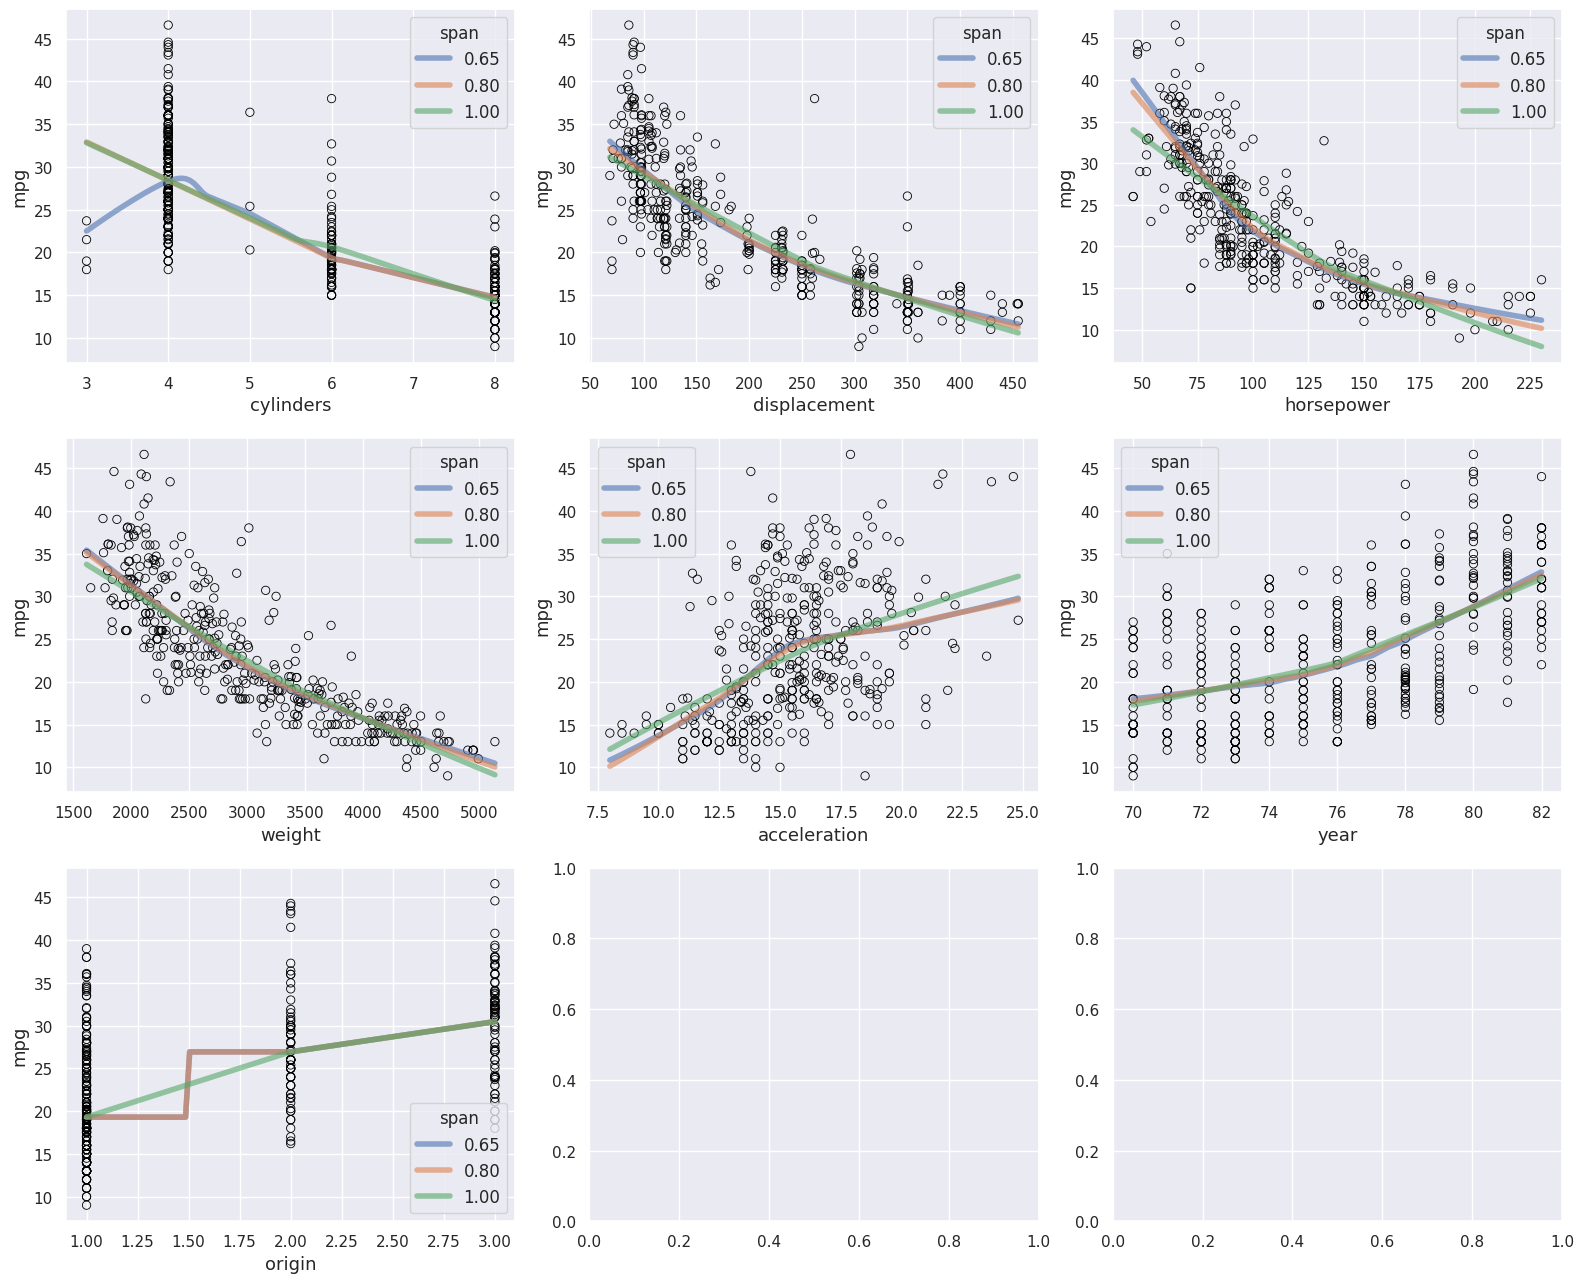

In [50]:
lowess = sm.nonparametric.lowess
fig, axes = plt.subplots(3, 3, figsize=(16,13))
axes = axes.flatten()
y = auto['mpg']

for i, col in enumerate(auto.columns.drop('mpg')):
    
    ax = axes[i]
    x_grid = np.linspace(auto[col].min(), auto[col].max(), 100)
    ax.scatter(auto[col], y, marker='o', facecolors='none', edgecolors='black', linewidths=0.6)

    for span in [0.65, 0.8, 1]:

        fitted = lowess(y,
                        auto[col],
                        frac=span,
                        xvals=x_grid)
        ax.plot(x_grid,
                fitted,
                label=f'{span:.2f}',
                linewidth=4,
                alpha=0.6)

    ax.set_xlabel(col, fontsize=13)
    ax.set_ylabel('mpg', fontsize=13);
    ax.legend(title='span', fontsize=12);

plt.tight_layout()


We can see that there's a strong non-linear inverse relationship between `mpg` and predictors like `displacement`, `horsepower`, `weight`, And a slightly non-linear concave relationship between `mpg` and `acceleration`.

### **Q9.**

In [51]:
boston = load_data('Boston')
boston.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

   lstat  medv  
0   4.98  24.0  
1   9.14  21.6  
2   4.03  34.7  
3   2.94  33.4  
4   5.33  36.2

In [52]:
boston.describe(include='all')

crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              age         dis         rad         tax     ptratio       lstat  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534   12.653063   
std     28.148861    2.105710    8.707259  168.537116    2.164946    7.141062   
min      2.900000    1.129600    1.000000  187.000000   12.600000    1.730000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000    6.950000   
50%     77.500000    3.207450    5.000000  330.000000   19.050000   11.360000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000   16.955000   
max    100.000000   12.126500   24.000000  711.000000   22.000000   37.970000   

             medv  
count  506.000000  
mean    22.532806  
std      9.197104  
min      5.000000  
25%     17.025000  
50%     21.200000  
75%     25.000000  
max     50.000000

**(a)**

In [53]:
dis = boston['dis']
nox = boston['nox']

In [54]:

design = MS([poly('dis', degree=3)]).fit(boston)

X = design.transform(boston)
y = nox

results = sm.OLS(y, X).fit()
summarize(results)

coef  std err        t  P>|t|
intercept               0.5547    0.003  201.021    0.0
poly(dis, degree=3)[0] -2.0031    0.062  -32.271    0.0
poly(dis, degree=3)[1]  0.8563    0.062   13.796    0.0
poly(dis, degree=3)[2] -0.3180    0.062   -5.124    0.0

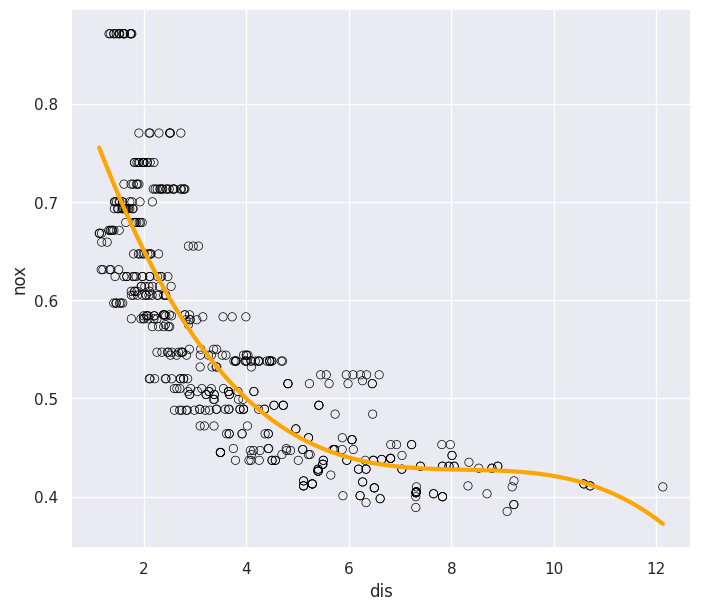

In [55]:
fig, ax = plt.subplots(figsize=(8, 7))
x = dis
ax.scatter(x, y, marker='o', facecolors='none', edgecolors='black', linewidths=0.5)

xs = np.linspace(x.min(), x.max(), 1000)
xs_df = pd.DataFrame({'dis': xs})
ax.plot(xs, results.predict(design.transform(xs_df)), c='orange', lw=3)

ax.set_xlabel('dis')
ax.set_ylabel('nox');

**(b)** I'll use sklearn's `Pipeline` and `PolynomialFeatures` to fit the polynomials for degrees $1, ..., 10$ since they're more straighforward than `poly` and are easier to use with cross-validation.

	Training RSS
degree 1: 2.7686
degree 2: 2.0353
degree 3: 1.9341
degree 4: 1.9330
degree 5: 1.9153
degree 6: 1.8783
degree 7: 1.8495
degree 8: 1.8356
degree 9: 1.8333
degree 10: 1.8322


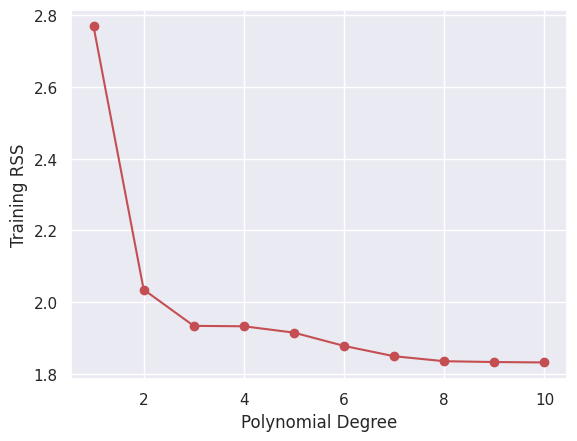

In [56]:
print('\tTraining RSS')
rss = {}
for i in range(1, 11):
    
    pipe = Pipeline([('poly', PolynomialFeatures(degree=i)),
                    ('linreg', skl.LinearRegression())])
    x = np.reshape(dis, (-1, 1))
    results = pipe.fit(x, y)
    training_rss = np.sum((results.predict(x) - y)**2)
    print(f"degree {i}: {training_rss:0.4f}")
    rss[i] = training_rss

plt.plot(rss.keys(), rss.values(), 'r-o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Training RSS');

Not surprising that the most flexible model got the lowest training RSS.

**(c)** Now we'll perform cross-validation to find the most optimal degree.

In [57]:
kfold = skm.KFold(5, shuffle=True, random_state=1)

pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                ('linreg', skl.LinearRegression())])

x = np.reshape(dis, (-1, 1))

param_grid = {'poly__degree': np.arange(1, 20)}
grid = skm.GridSearchCV(pipe, param_grid=param_grid, cv=kfold)

results = grid.fit(x, y)
results

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('linreg', LinearRegression())]),
             param_grid={'poly__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [58]:
results.best_params_

{'poly__degree': 3}

Cross-validation found the optimal degree to be $3$ which is reasonable considering the plot from earlier **(a)** was a pretty good fit to the data with no big signs of overfitting.

**(d)**

In [59]:
x = dis

design = MS([bs('dis',
                 internal_knots=[(dis.max() -dis.min())/2], 
                 degree=3)]).fit(boston)

X = design.transform(boston)
y = nox

results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nox   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     314.3
Date:                Thu, 27 Mar 2025   Prob (F-statistic):          4.83e-135
Time:                        06:16:15   Log-Likelihood:                 690.66
No. Observations:                 506   AIC:                            -1371.
Df Residuals:                     501   BIC:                            -1350.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
intercept                                          0.7596      0.011     71.651      0.000       0.739       0.780
bs(dis, internal_knots=[5.49845], degree=3)[0]    -0.2104      0.023     -9.252      0.000      -0.255      -0.166
bs(dis, internal_knots=[5.49845], degree=3)[1]    -0.3793      0.025    -15.218      0.000      -0.428      -0.330
bs(dis, internal_knots=[5.49845], degree=3)[2]    -0.3183      0.041     -7.839      0.000      -0.398      -0.239
bs(dis, internal_knots=[5.49845], degree=3)[3]    -0.3693      0.050     -7.425      0.000      -0.467      -0.272
==============================================================================
Omnibus:                       63.904   Durbin-Watson:                   0.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.057
Skew:                           0.912   Prob(JB):                     1.25e-19
Kurtosis:                       3.896   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

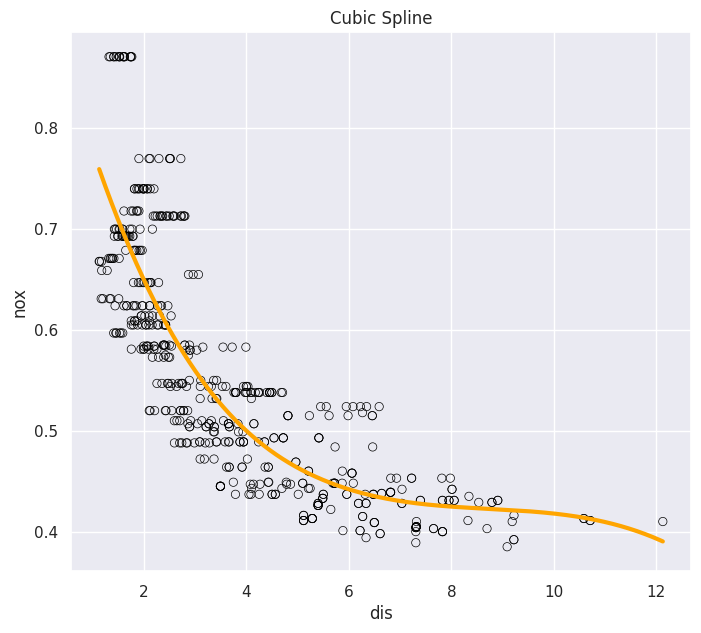

In [60]:
fig, ax = plt.subplots(figsize=(8, 7))
x = dis
ax.scatter(x, y, marker='o', facecolors='none', edgecolors='black', linewidths=0.5)

xs = np.linspace(x.min(), x.max(), 1000)
xs_df = pd.DataFrame({'dis': xs})
ax.plot(xs, results.predict(design.transform(xs_df)), c='orange', lw=3)

ax.set_title('Cubic Spline')
ax.set_xlabel('dis')
ax.set_ylabel('nox');

I chose one knot in the middle of the range to get 4 degrees of freedom.

The knot is at the following point:

In [61]:
(dis.max() -dis.min())/2

5.49845

**(e)**

		Training RSS
degree of freedom 3: 1.9341
degree of freedom 4: 1.9228
degree of freedom 5: 1.8402
degree of freedom 6: 1.8340
degree of freedom 7: 1.8299
degree of freedom 8: 1.8170
degree of freedom 9: 1.8257
degree of freedom 10: 1.7925
degree of freedom 11: 1.7970


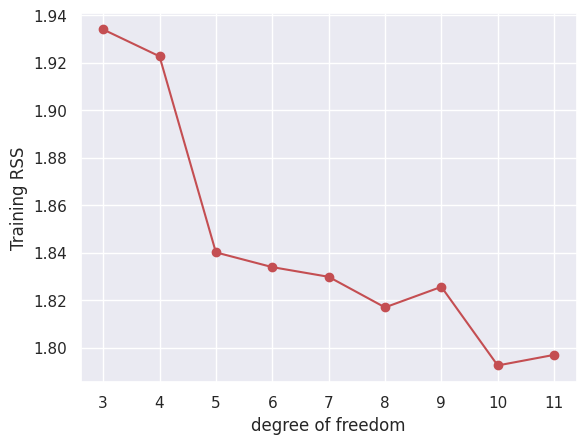

In [62]:
print('\t\tTraining RSS')
results_dict = {}
for i in range(3, 12):
    
    design = MS([bs('dis',
                    df=i, 
                    degree=3)]).fit(boston)

    X = design.transform(boston)
    y = nox

    results = sm.OLS(y, X).fit()
    
    training_rss = np.sum((results.predict(X) - y)**2)
    print(f"degree of freedom {i}: {training_rss:0.4f}")
    results_dict[i] = (design, results, training_rss)

rss_values = [value[2] for value in results_dict.values()]
plt.plot(results_dict.keys(), rss_values, 'r-o')
plt.xlabel('degree of freedom')
plt.ylabel('Training RSS');

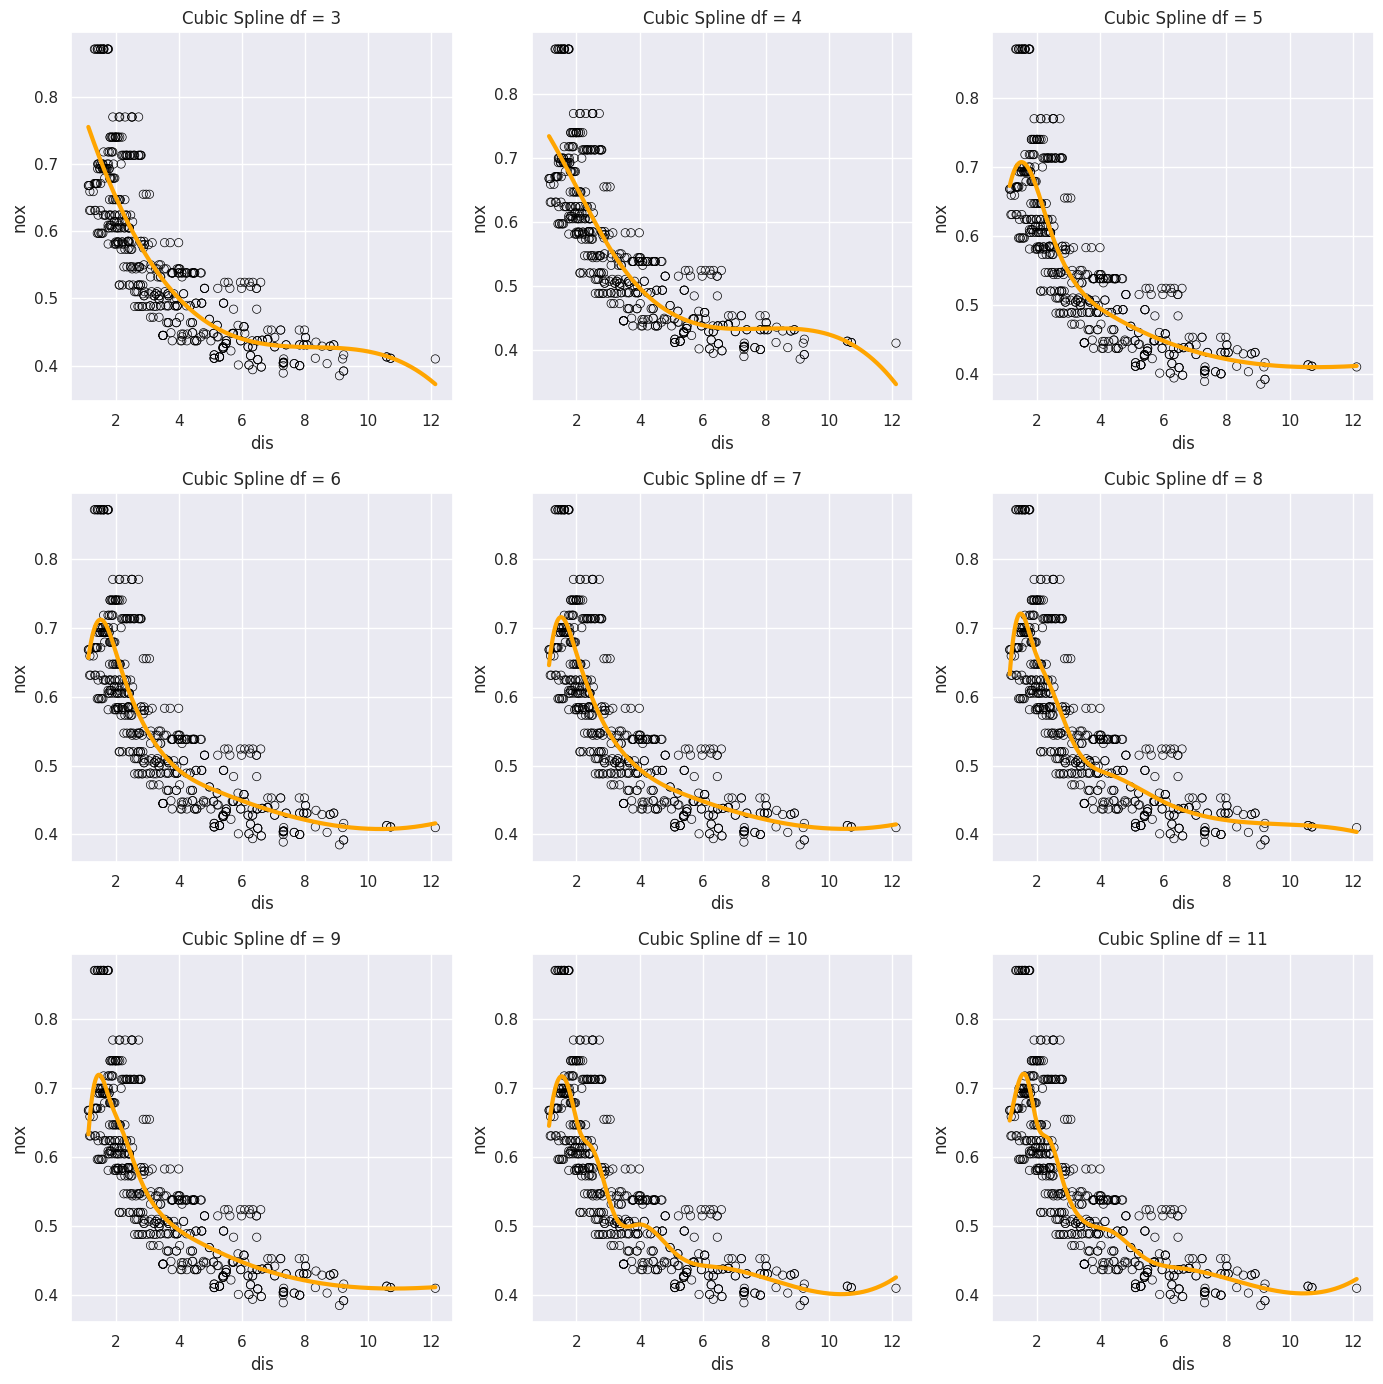

In [63]:
fig, axes = plt.subplots(3, 3, figsize=(14, 14))
axes = axes.flatten()

x = dis
xs = np.linspace(x.min(), x.max(), 1000)
xs_df = pd.DataFrame({'dis': xs})

for idx, value in results_dict.items():
    design, model, _ = value
    ax = axes[idx-3]
    
    ax.scatter(x, y, marker='o', facecolors='none', edgecolors='black', linewidths=0.5)
    ax.plot(xs, model.predict(design.transform(xs_df)), c='orange', lw=3)

    ax.set_title(f'Cubic Spline df = {idx}')
    ax.set_xlabel('dis')
    ax.set_ylabel('nox')
    plt.tight_layout();

We can see that the model starts overfitting to the beginning of the data pretty quickly as the degrees of freedom increase.  

**(f)** Again for cross-validation I'll use the sklearn implementation since it's more straightforward.

In [64]:
kfold = skm.KFold(7, shuffle=True, random_state=1)

pipe = Pipeline([('spline', SplineTransformer(n_knots=2, degree=3, knots='quantile')),
                ('linreg', skl.LinearRegression())])

x = np.reshape(dis, (-1, 1))

param_grid = {'spline__degree': np.arange(1, 20),
            'spline__n_knots': np.arange(2, 20)}

grid = skm.GridSearchCV(pipe, param_grid=param_grid, cv=kfold)

results = grid.fit(x, y)
results

GridSearchCV(cv=KFold(n_splits=7, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('spline',
                                        SplineTransformer(knots='quantile',
                                                          n_knots=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'spline__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'spline__n_knots': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])})

In [65]:
best_estimator = results.best_estimator_
results.best_params_

{'spline__degree': 2, 'spline__n_knots': 8}

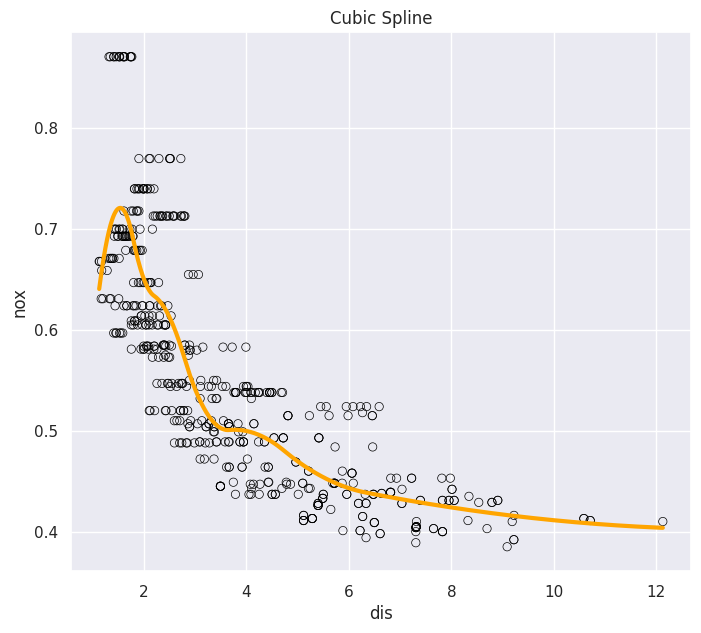

In [66]:
fig, ax = plt.subplots(figsize=(8, 7))
x = dis
ax.scatter(x, y, marker='o', facecolors='none', edgecolors='black', linewidths=0.5)

xs = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
ax.plot(xs, best_estimator.predict(xs), c='orange', lw=3)

ax.set_title('Cubic Spline')
ax.set_xlabel('dis')
ax.set_ylabel('nox');

Cross-validation picked the estimator with `degree=2` and `n_knots=8`, which is $3+ \text{n\_knots} = 8$ degrees of freedom.

### **Q10.**

In [67]:
college = load_data('College')
college.head()

Private  Apps  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  \
0     Yes  1660    1232     721         23         52         2885   
1     Yes  2186    1924     512         16         29         2683   
2     Yes  1428    1097     336         22         50         1036   
3     Yes   417     349     137         60         89          510   
4     Yes   193     146      55         16         44          249   

   P.Undergrad  Outstate  Room.Board  Books  Personal  PhD  Terminal  \
0          537      7440        3300    450      2200   70        78   
1         1227     12280        6450    750      1500   29        30   
2           99     11250        3750    400      1165   53        66   
3           63     12960        5450    450       875   92        97   
4          869      7560        4120    800      1500   76        72   

   S.F.Ratio  perc.alumni  Expend  Grad.Rate  
0       18.1           12    7041         60  
1       12.2           16   10527         56  
2       12.9           30    8735         54  
3        7.7           37   19016         59  
4       11.9            2   10922         15

In [68]:
college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Private      777 non-null    category
 1   Apps         777 non-null    int64   
 2   Accept       777 non-null    int64   
 3   Enroll       777 non-null    int64   
 4   Top10perc    777 non-null    int64   
 5   Top25perc    777 non-null    int64   
 6   F.Undergrad  777 non-null    int64   
 7   P.Undergrad  777 non-null    int64   
 8   Outstate     777 non-null    int64   
 9   Room.Board   777 non-null    int64   
 10  Books        777 non-null    int64   
 11  Personal     777 non-null    int64   
 12  PhD          777 non-null    int64   
 13  Terminal     777 non-null    int64   
 14  S.F.Ratio    777 non-null    float64 
 15  perc.alumni  777 non-null    int64   
 16  Expend       777 non-null    int64   
 17  Grad.Rate    777 non-null    int64   
dtypes: category(1), float64(1), in

In [69]:
college.describe(include='category')

Private
count      777
unique       2
top        Yes
freq       565

In [70]:
college.describe()

Apps        Accept       Enroll   Top10perc   Top25perc  \
count    777.000000    777.000000   777.000000  777.000000  777.000000   
mean    3001.638353   2018.804376   779.972973   27.558559   55.796654   
std     3870.201484   2451.113971   929.176190   17.640364   19.804778   
min       81.000000     72.000000    35.000000    1.000000    9.000000   
25%      776.000000    604.000000   242.000000   15.000000   41.000000   
50%     1558.000000   1110.000000   434.000000   23.000000   54.000000   
75%     3624.000000   2424.000000   902.000000   35.000000   69.000000   
max    48094.000000  26330.000000  6392.000000   96.000000  100.000000   

        F.Undergrad   P.Undergrad      Outstate   Room.Board        Books  \
count    777.000000    777.000000    777.000000   777.000000   777.000000   
mean    3699.907336    855.298584  10440.669241  4357.526384   549.380952   
std     4850.420531   1522.431887   4023.016484  1096.696416   165.105360   
min      139.000000      1.000000   2340.000000  1780.000000    96.000000   
25%      992.000000     95.000000   7320.000000  3597.000000   470.000000   
50%     1707.000000    353.000000   9990.000000  4200.000000   500.000000   
75%     4005.000000    967.000000  12925.000000  5050.000000   600.000000   
max    31643.000000  21836.000000  21700.000000  8124.000000  2340.000000   

          Personal         PhD    Terminal   S.F.Ratio  perc.alumni  \
count   777.000000  777.000000  777.000000  777.000000   777.000000   
mean   1340.642214   72.660232   79.702703   14.089704    22.743887   
std     677.071454   16.328155   14.722359    3.958349    12.391801   
min     250.000000    8.000000   24.000000    2.500000     0.000000   
25%     850.000000   62.000000   71.000000   11.500000    13.000000   
50%    1200.000000   75.000000   82.000000   13.600000    21.000000   
75%    1700.000000   85.000000   92.000000   16.500000    31.000000   
max    6800.000000  103.000000  100.000000   39.800000    64.000000   

             Expend  Grad.Rate  
count    777.000000  777.00000  
mean    9660.171171   65.46332  
std     5221.768440   17.17771  
min     3186.000000   10.00000  
25%     6751.000000   53.00000  
50%     8377.000000   65.00000  
75%    10830.000000   78.00000  
max    56233.000000  118.00000

**(a)**

In [71]:
college['Private'] = college['Private'] == 'Yes'

In [72]:
X_train, X_test, y_train, y_test = skm.train_test_split(college.drop('Outstate', axis=1), college['Outstate'], test_size=0.3, random_state=1)

Now to perform forward stepwise selection we'll use the sklearn implementation `SequentialFeatureSelector` instead of the tedious `Stepwise` method from the ISLP package.

In [73]:
cv_scores = []
num_features = np.arange(1, X_train.shape[1])

model = skl.LinearRegression()

for n_features in num_features:
    
    sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select=n_features, 
                                    direction='forward', 
                                    cv=5, 
                                    n_jobs=-1)

    X_selected = sfs.fit_transform(X_train, y_train)
    
    scores = skm.cross_val_score(model, sfs.transform(X_test), y_test, cv=5)
    
    cv_scores.append(np.mean(scores))

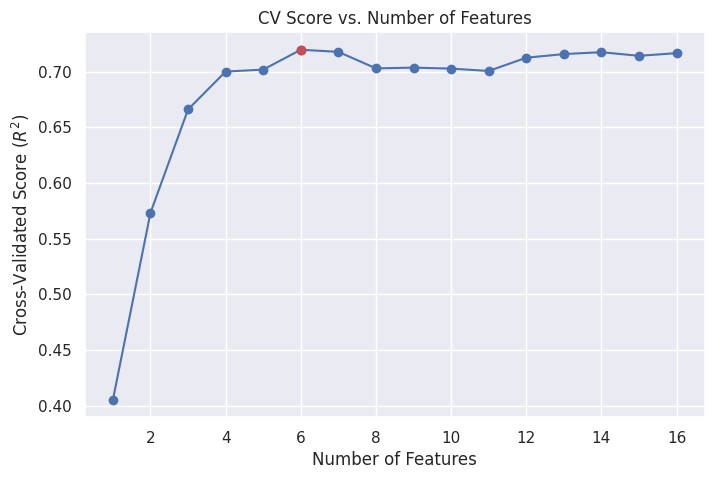

(6, 0.7196245697171475)

In [74]:
plt.figure(figsize=(8, 5))
plt.plot(num_features, cv_scores, marker='o')

plt.scatter(num_features[np.argmax(cv_scores)], np.max(cv_scores), c='r', zorder=np.infty)
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Score $(R^2)$')
plt.title('CV Score vs. Number of Features')
plt.show();
num_features[np.argmax(cv_scores)], np.max(cv_scores)

In [75]:
sfs = SequentialFeatureSelector(model, 
                                n_features_to_select=6, 
                                direction='forward', 
                                cv=5, 
                                n_jobs=-1)

X_selected = sfs.fit_transform(X_train, y_train)

In [76]:
selected_columns = X_train.columns[sfs.get_support()]
selected_columns

Index(['Private', 'Room.Board', 'PhD', 'perc.alumni', 'Expend', 'Grad.Rate'], dtype='object')

These are the predictors selected by forward stepwise selection.

**(b)** Now we'll fit a GAM model to the selected features with a factor term for the `Private` predictor since it's categorical and 5 spline terms for the other predictors.

In [77]:
gam = LinearGAM(f_gam(0, lam=0) +
                s_gam(1, lam=0.6) +
                s_gam(2, lam=20) +
                s_gam(3, lam=20) +
                s_gam(4, lam=0.6) +
                s_gam(5, lam=10))
gam.fit(X_selected, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + intercept, 
   tol=0.0001, verbose=False)

I picked these penalty values after a few fits and decided that some curves could use some smoothing out.

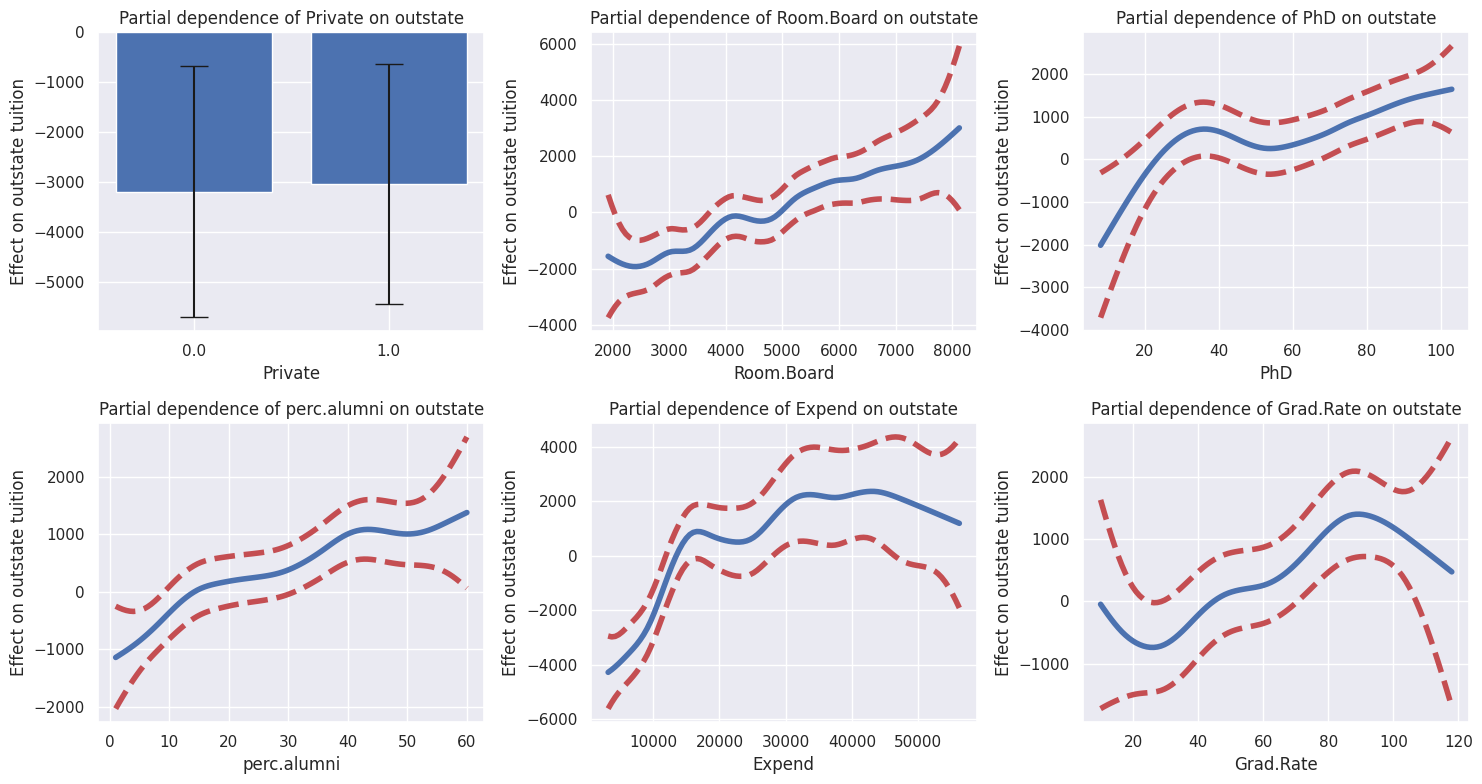

In [78]:
n_plots = len(selected_columns)
n_rows = math.ceil(n_plots/3)
n_cols = math.ceil(n_plots/n_rows)

_, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(selected_columns):
    ax = axes[i]
    
    plot_gam(gam, i, ax=ax)
    
    ax.set_xlabel(col)     
    ax.set_ylabel(f'Effect on outstate tuition')
    ax.set_title(f'Partial dependence of {col} on outstate')

plt.tight_layout()

**(c)** We'll evaluate model performance by calculating the RMSE.

In [79]:
rmse = np.sqrt(np.mean((y_test - gam.predict(sfs.transform(X_test)))**2))
rmse

1857.189949133758

In [80]:
college['Outstate'].mean(), college['Outstate'].std()

(10440.66924066924, 4023.016484111974)

We can see that our model makes pretty good predictions that fall within $0.5\sigma$.

In [81]:
rmse/college['Outstate'].std()

0.4616411482449363

**(d)**

The non-linear relationship seems to be most pronounced for the variables `Expend`, `PhD`.

`Grad.Rate` looks like it has a non-linear relationship but that could be simply due to the lack of data at the boundaries, as you can see the confidence interval is pretty wide at its boundaries.

### **Q11.**

**(a)**

In [82]:
rng = np.random.default_rng(5)
x1 = rng.normal(0, 1, 100) 
x2 = rng.normal(0, 1, 100)
eps = rng.normal(0, 10, 100)
y =  4 + 7 * x1 + 2.5 * x2 + eps

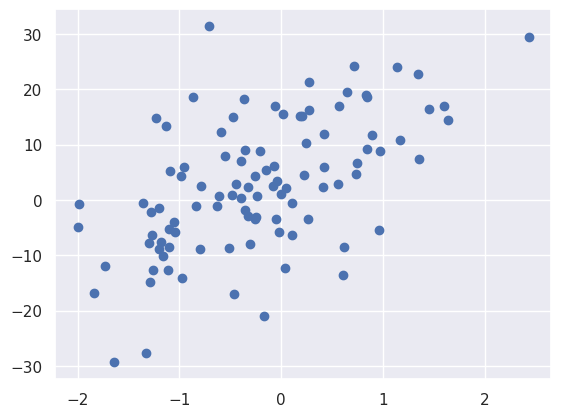

In [83]:
plt.scatter(x1, y);

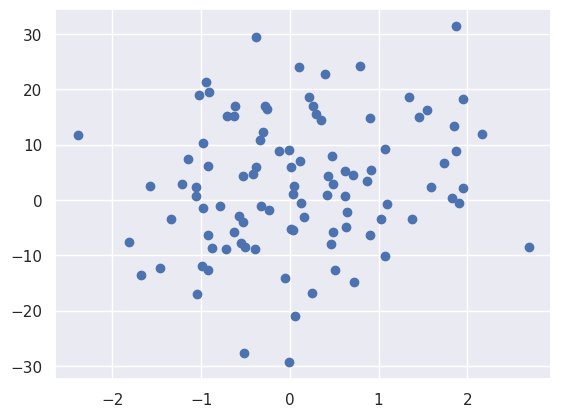

In [84]:
plt.scatter(x2, y);

**(b)**

In [85]:
def simple_reg(outcome, feature):
    y = outcome
    x = feature
    
    beta1 = sum((x - x.mean()) * (y - y.mean()))/(np.sum((x - x.mean())**2))
    beta0 = y.mean() - beta1 * x.mean()
    
    return beta0, beta1

**(c)** 

In [86]:
beta1 = 2

**(d)**

In [87]:
beta0, beta2 = simple_reg(y - beta1 * x1, x2)
beta0, beta2

(3.0020617834203165, 2.1940648698152145)

**(e)**

In [88]:
beta0, beta1 = simple_reg(y - beta2 * x2, x1)
beta0, beta1

(4.307932494470254, 7.82959083901761)

**(f)** I believe the question means to repeat (d) and (e) not (c) and (d) for a thousand iterations as (c) just initiliazes a value for `beta1`.

In [89]:
iter_dict = {}
beta0 = beta1 = beta2 = 0
for i in range(1000):
    beta0, beta2 = simple_reg(y - beta1 * x1, x2)
    beta0, beta1 = simple_reg(y - beta2 * x2, x1)
    # if i % 10 ==0:
    iter_dict[i] = [beta0, beta1, beta2]
    print(f"iter {i}: {beta0}, {beta1}, {beta2}")
    
beta0, beta1, beta2

iter 0: 4.317527003764373, 7.819020992890909, 2.0670041568030446
iter 1: 4.280017168970773, 7.860343917269069, 2.563749348009967
iter 2: 4.2798189323797695, 7.860562305745158, 2.5663746081275867
iter 3: 4.279817884714638, 7.860563459911453, 2.566388482425328
iter 4: 4.279817879177808, 7.860563466011133, 2.5663885557499246
iter 5: 4.279817879148546, 7.860563466043369, 2.566388556137441
iter 6: 4.279817879148392, 7.860563466043541, 2.5663885561394872
iter 7: 4.279817879148391, 7.860563466043541, 2.5663885561394992
iter 8: 4.279817879148391, 7.860563466043541, 2.5663885561394992
iter 9: 4.279817879148391, 7.860563466043541, 2.5663885561394992
iter 10: 4.279817879148391, 7.860563466043541, 2.5663885561394992
iter 11: 4.279817879148391, 7.860563466043541, 2.5663885561394992
iter 12: 4.279817879148391, 7.860563466043541, 2.5663885561394992
iter 13: 4.279817879148391, 7.860563466043541, 2.5663885561394992
iter 14: 4.279817879148391, 7.860563466043541, 2.5663885561394992
iter 15: 4.27981787914

(4.279817879148391, 7.860563466043541, 2.5663885561394992)

We can see that convergence happens so fast for our model here (around 3 iterations for 5 significant digits).

In [90]:
df = pd.DataFrame(iter_dict.values(), columns=['beta0', 'beta1', 'beta2'], index=iter_dict.keys())
df.head()

beta0     beta1     beta2
0  4.317527  7.819021  2.067004
1  4.280017  7.860344  2.563749
2  4.279819  7.860562  2.566375
3  4.279818  7.860563  2.566388
4  4.279818  7.860563  2.566389

I'll plot the first 5 coefficients first since there's a slightly visible change in them unlike the less interesting 1000 which are pretty much straight lines.

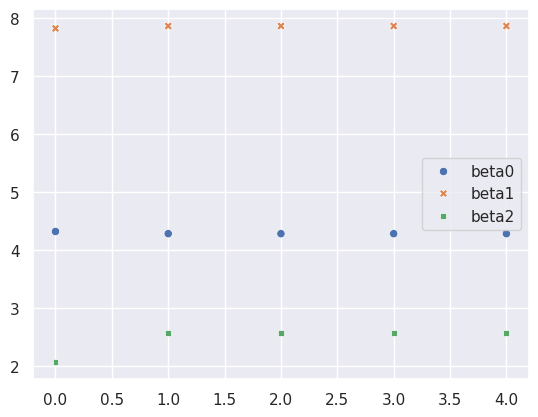

In [91]:
sns.scatterplot(df[:5]);

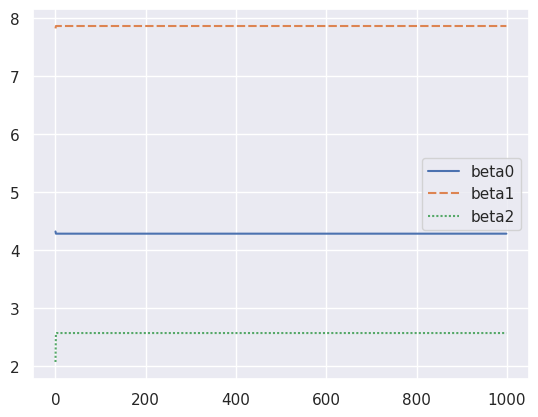

In [92]:
sns.lineplot(df);

**(g)**

In [93]:
data = pd.DataFrame({'x1':x1, 
                     'x2':x2, 
                     'y':y})

X = MS(['x1', 'x2']).fit_transform(data)
results = sm.OLS(y, X).fit()
summarize(results)

coef  std err      t  P>|t|
intercept  4.2798    0.997  4.293  0.000
x1         7.8606    1.095  7.181  0.000
x2         2.5664    0.957  2.683  0.009

We'll compare both methods now.

In [94]:
results.params - [beta0, beta1, beta2]

intercept    3.552714e-15
x1           1.776357e-15
x2          -1.332268e-15
dtype: float64

We can see it's a very miniscule difference.

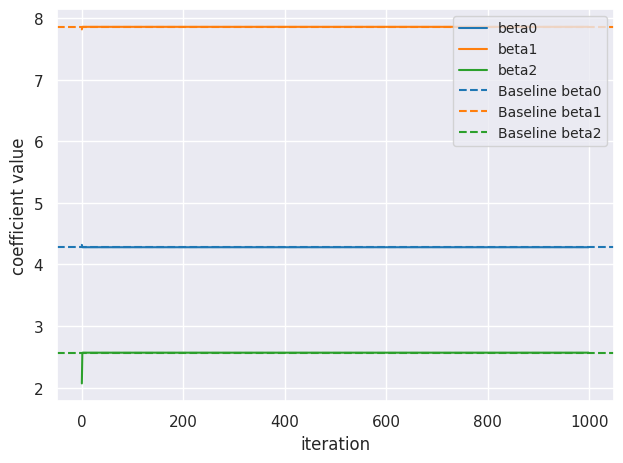

In [95]:
# Create a 5x4 grid of subplots (20 subplots total)
fig, ax = plt.subplots()
    
    
# Use a fixed palette for consistency between data and baseline lines
palette = sns.color_palette("tab10", n_colors=3)

# Plot the data lines with seaborn. The hue mapping uses our palette.
sns.lineplot(data=df, ax=ax, palette=palette, dashes=False)

# Plot baseline lines for each column in the group.
# Each baseline is drawn as a dashed horizontal line at the coefficient value.
for idx, col in enumerate(df.columns):
    baseline_val = results.params.iloc[idx]
    ax.axhline(y=baseline_val, color=palette[idx], linestyle='--', label=f"Baseline {col}")

ax.legend(loc='upper right', fontsize='small')
ax.set_xlabel('iteration')
ax.set_ylabel('coefficient value')
plt.tight_layout()
plt.show()

**(h)**

By iteration 3 the backfitting method was accurate up to 5 significant digits.

In [96]:
np.abs(results.params - df.iloc[2,:].values)

intercept    0.000001
x1           0.000001
x2           0.000014
dtype: float64

And up to around 8 significant digits by iteration 4.

In [97]:
np.abs(results.params - df.iloc[3,:].values)

intercept    5.566243e-09
x1           6.132090e-09
x2           7.371417e-08
dtype: float64

### **Q12.**

We'll start by creating 100 predictors $X_1, ..., X_{100}$ drawn from standard normal distributions and a $100$ integer coefficients in the range $[-10, 10]$.

I'm setting the sample size $n = 101$ instead of $100$ so the matrix does not become saturated and to avoid warnings from `sm.OLS` later.

In [98]:
n = 101
p = 100
rng = np.random.default_rng(7)
coefs = rng.integers(-10, 11, size=p)
eps = rng.normal(0, 4, size=n)

data100 = pd.DataFrame({f"x{i}":rng.normal(0, 1, n) for i in range(1, p + 1)}) 
data100.head()

x1        x2        x3        x4        x5        x6        x7  \
0 -0.694404 -0.530115  0.292268 -1.085816  0.552340  0.675451 -1.084599   
1 -0.326685  1.333560 -0.205311 -0.102069 -1.664602  0.260088 -0.373664   
2 -0.560231  0.047120  0.214454  0.051955  0.460453 -0.922971  2.280556   
3  0.007959 -1.172546  0.296739  0.958463  0.243037  0.072866 -0.069594   
4 -0.375267 -0.940700 -0.298774 -0.906269  0.283376 -0.351278 -0.238661   

         x8        x9       x10  ...       x91       x92       x93       x94  \
0 -0.479336  0.808410  0.884749  ...  0.474795  1.033411  1.076624 -0.594797   
1  0.938149 -0.318144  0.864653  ...  0.146766 -1.358934  0.616559  0.043102   
2 -0.601504  1.855783 -0.373815  ...  1.887452  0.405447 -0.586072 -0.402486   
3 -0.157427  1.700440 -1.117763  ... -2.416341  0.132935 -0.576968  0.337267   
4  2.486350 -1.954211 -1.549745  ... -1.545858 -0.445181 -0.034345 -1.334770   

        x95       x96       x97       x98       x99      x100  
0 -0.556457  0.353752 -0.836014  1.570142 -0.222130  0.441849  
1  1.835143  0.149400  2.312694  0.445838  0.371477  0.649667  
2 -0.248234 -1.134712  1.141353 -2.202446  1.250827 -0.016700  
3  1.911494  1.170559  1.220760  1.798199 -0.577544 -0.688981  
4  1.166775  0.318499 -0.356279  0.217479 -0.811713 -0.006864  

[5 rows x 100 columns]

In [99]:
coefs

array([  9,   3,   4,   8,   2,   6,   7,  -6,  -9,  -4,  -5,   8,   9,
       -10,   0,   7,  -8,   6,  -8,  -1,   7,  -4,  -3,  -5,   5,  -5,
        10,  -1,   0,   0,   2,   1,   0,  10,   6,   6,   4,   3,  -3,
        10,  -1,  -6,   7,  -7,   8,   2,  -8, -10,  -1, -10,  -8,   0,
        10,  -1,   6,   9,   7,   3,  -1,   0,  -5,   0,  -3,  -5,  10,
       -10,  -8,  -6,  10,   4,   8,  -6,   5,  -3,   0, -10,   2,   7,
         3,  -7,   1,  -5,  10,   8,  -7,   0,   9,   7,   4,   3, -10,
         5,  -1,  -9,  -5,   1,   5,   0,   2,   8])

Our response $Y$ will be a sum of all the $\beta_i X_i$ terms plus a noise term $\epsilon$.

In [100]:
data100['y'] = data100.dot(coefs) + eps
data100.head()

x1        x2        x3        x4        x5        x6        x7  \
0 -0.694404 -0.530115  0.292268 -1.085816  0.552340  0.675451 -1.084599   
1 -0.326685  1.333560 -0.205311 -0.102069 -1.664602  0.260088 -0.373664   
2 -0.560231  0.047120  0.214454  0.051955  0.460453 -0.922971  2.280556   
3  0.007959 -1.172546  0.296739  0.958463  0.243037  0.072866 -0.069594   
4 -0.375267 -0.940700 -0.298774 -0.906269  0.283376 -0.351278 -0.238661   

         x8        x9       x10  ...       x92       x93       x94       x95  \
0 -0.479336  0.808410  0.884749  ...  1.033411  1.076624 -0.594797 -0.556457   
1  0.938149 -0.318144  0.864653  ... -1.358934  0.616559  0.043102  1.835143   
2 -0.601504  1.855783 -0.373815  ...  0.405447 -0.586072 -0.402486 -0.248234   
3 -0.157427  1.700440 -1.117763  ...  0.132935 -0.576968  0.337267  1.911494   
4  2.486350 -1.954211 -1.549745  ... -0.445181 -0.034345 -1.334770  1.166775   

        x96       x97       x98       x99      x100          y  
0  0.353752 -0.836014  1.570142 -0.222130  0.441849 -20.430838  
1  0.149400  2.312694  0.445838  0.371477  0.649667   6.147675  
2 -1.134712  1.141353 -2.202446  1.250827 -0.016700 -45.849696  
3  1.170559  1.220760  1.798199 -0.577544 -0.688981   7.119777  
4  0.318499 -0.356279  0.217479 -0.811713 -0.006864 -87.132218  

[5 rows x 101 columns]

In [101]:
data100.describe()

x1          x2          x3          x4          x5          x6  \
count  101.000000  101.000000  101.000000  101.000000  101.000000  101.000000   
mean    -0.188754    0.051707   -0.089834   -0.342449    0.003727    0.039669   
std      0.977752    0.908521    0.927207    0.888110    0.951015    1.020977   
min     -3.251438   -2.613559   -1.946678   -2.819569   -2.760418   -2.309521   
25%     -0.806846   -0.555248   -0.754022   -0.977258   -0.600947   -0.539778   
50%     -0.142903   -0.002029   -0.132070   -0.294354    0.204663   -0.068876   
75%      0.493932    0.577047    0.514521    0.091685    0.584146    0.671333   
max      2.025161    2.015516    2.536930    1.908217    1.957445    2.532306   

               x7          x8          x9         x10  ...         x92  \
count  101.000000  101.000000  101.000000  101.000000  ...  101.000000   
mean    -0.168156    0.191067   -0.047862   -0.030087  ...    0.028333   
std      0.957645    0.908086    0.994167    1.044035  ...    1.080511   
min     -2.100440   -2.133884   -2.259497   -2.405364  ...   -3.412312   
25%     -0.802186   -0.457107   -0.792173   -0.717843  ...   -0.701115   
50%     -0.199655    0.120471   -0.070865   -0.061462  ...    0.132935   
75%      0.435367    0.812917    0.633794    0.647760  ...    0.710309   
max      2.571669    2.486350    2.440462    2.508994  ...    2.632762   

              x93         x94         x95         x96         x97         x98  \
count  101.000000  101.000000  101.000000  101.000000  101.000000  101.000000   
mean     0.107951    0.127211    0.082461    0.069857    0.059035   -0.014487   
std      1.013363    1.052838    0.964704    1.093956    1.132628    1.090097   
min     -2.567531   -1.749875   -2.135391   -2.961898   -2.804388   -2.498290   
25%     -0.576968   -0.750318   -0.556457   -0.685126   -0.599964   -0.649413   
50%      0.198333    0.092704    0.043114    0.160276    0.053884    0.141063   
75%      0.785195    0.985852    0.762508    0.885498    0.694165    0.767484   
max      2.475546    2.491695    2.215750    2.423589    3.632931    2.424722   

              x99        x100           y  
count  101.000000  101.000000  101.000000  
mean    -0.051020   -0.029952  -11.055107  
std      0.985822    0.982725   64.962322  
min     -2.802652   -2.062214 -148.859438  
25%     -0.634373   -0.688981  -52.681323  
50%     -0.214611   -0.007977  -13.781208  
75%      0.690311    0.590520   25.562973  
max      2.112505    2.632648  170.171354  

[8 rows x 101 columns]

In [102]:
def simple_reg(outcome, feature):
    y = outcome
    x = feature

    beta1 = np.sum((x - x.mean()) * (y - y.mean()))/(np.sum((x - x.mean())**2))
    beta0 = y.mean() - beta1 * x.mean()
    return beta0, beta1


def backfit(df: pd.DataFrame, response: str, max_iterations=1000):
    X_df = df.drop(response, axis=1)
    
    iter_dict = {}
    coefs = np.ones(len(df.columns)-1)
    
    for i in range(max_iterations):
        for j, col in enumerate(X_df.columns):
            # fit model on column j while holding all others constant and ignore the intercept
            _ , coefs[j] = simple_reg(
                    df[response] -  X_df.loc[:, X_df.columns != col].dot(np.delete(coefs, j)),
                    X_df.iloc[:, j]
                )
        iter_dict[i] = coefs
        
    return iter_dict

In [103]:
backfit_results = backfit(data100, 'y', max_iterations=1000)
final_results = backfit_results[list(backfit_results.keys())[-1]]
final_results

array([ 8.57112098e+00,  3.70741572e+00,  3.47337638e+00,  4.68503048e+00,
        6.24588909e-01,  8.02640881e+00,  4.23987354e+00, -6.03461905e+00,
       -7.06804991e+00, -2.72535620e+00, -6.04071987e+00,  1.03041912e+01,
        1.16840477e+01, -9.25075619e+00,  1.00064332e+00,  9.63917741e+00,
       -7.34386057e+00,  8.85059566e+00, -3.88228087e+00,  3.36003252e-01,
        7.51295395e+00, -4.38840321e+00,  2.08112935e+00,  1.09818560e+00,
        3.67249134e+00, -2.77778291e+00,  8.18339805e+00,  1.79726256e+00,
       -4.30130048e+00,  2.62805183e+00,  2.25731510e-01,  2.26321752e+00,
        1.91491039e+00,  9.20720719e+00,  5.54078131e+00,  6.06956898e+00,
        2.89175935e+00,  6.24697170e+00, -3.70104350e+00,  8.56869727e+00,
        6.72379107e-01, -4.96452568e+00,  8.69038160e+00, -6.79213143e+00,
        4.60505003e+00, -5.77148948e-01, -6.64119591e+00, -9.63568129e+00,
        4.00557815e+00, -6.39587309e+00, -8.88411389e+00, -2.50658472e+00,
        1.17367882e+01,  

We'll check on the $\text{MAE}$ between the coefficients we got and the true underlying coefficients.

In [104]:
np.mean(np.abs(coefs - final_results))

1.865078631822381

Which is not bad considering the $\text{mean}$ and $\text{stddev}$ of the true coefficients.

In [105]:
coefs.mean(), coefs.std()

(0.72, 6.110777364623915)

In [106]:
backfit_df = pd.DataFrame.from_dict(backfit_results, orient='index')
backfit_df.columns = data100.columns.drop('y')
backfit_df.head()

x1        x2        x3       x4        x5        x6        x7  \
0  8.571121  3.707416  3.473376  4.68503  0.624589  8.026409  4.239874   
1  8.571121  3.707416  3.473376  4.68503  0.624589  8.026409  4.239874   
2  8.571121  3.707416  3.473376  4.68503  0.624589  8.026409  4.239874   
3  8.571121  3.707416  3.473376  4.68503  0.624589  8.026409  4.239874   
4  8.571121  3.707416  3.473376  4.68503  0.624589  8.026409  4.239874   

         x8       x9       x10  ...        x91       x92       x93       x94  \
0 -6.034619 -7.06805 -2.725356  ... -10.691413  4.297383  1.087051 -9.074825   
1 -6.034619 -7.06805 -2.725356  ... -10.691413  4.297383  1.087051 -9.074825   
2 -6.034619 -7.06805 -2.725356  ... -10.691413  4.297383  1.087051 -9.074825   
3 -6.034619 -7.06805 -2.725356  ... -10.691413  4.297383  1.087051 -9.074825   
4 -6.034619 -7.06805 -2.725356  ... -10.691413  4.297383  1.087051 -9.074825   

        x95       x96      x97       x98       x99       x100  
0 -4.814369  2.915269  3.86411  2.357343  0.865348  10.629088  
1 -4.814369  2.915269  3.86411  2.357343  0.865348  10.629088  
2 -4.814369  2.915269  3.86411  2.357343  0.865348  10.629088  
3 -4.814369  2.915269  3.86411  2.357343  0.865348  10.629088  
4 -4.814369  2.915269  3.86411  2.357343  0.865348  10.629088  

[5 rows x 100 columns]

In [107]:
X = MS(data100.columns.drop('y'), intercept=False).fit_transform(data100)
results = sm.OLS(data100['y'], X).fit()
summarize(results)

coef  std err      t  P>|t|
x1    8.9331    7.355  1.215  0.438
x2    4.7279    4.561  1.037  0.489
x3    4.4370    4.725  0.939  0.520
x4    5.3049    5.407  0.981  0.506
x5    0.7438    4.395  0.169  0.893
...      ...      ...    ...    ...
x96   0.4842    3.387  0.143  0.910
x97   4.5245    6.536  0.692  0.615
x98   0.3164    4.599  0.069  0.956
x99   2.2474    9.718  0.231  0.855
x100  7.6208   10.415  0.732  0.598

[100 rows x 4 columns]

In [108]:
results.params[results.pvalues <= 0.05]

Series([], dtype: float64)

The t-statistics and p-values aren't significant mostly because there's only 1 degree of freedom to calculate them $n = 101, p = 100$.

We can see that the $\text{MAE}$ for the coefficients of the multiple regression model and the ones we got using backfitting isn't that big.  

In [109]:
np.mean(np.abs(results.params - final_results))

1.5048746861790105

We'll split the 100 predictors on 20 plots 5 predictors each, we'll use solid lines for the backfitted coefficient values and dashed lines for the coefficients obtained from the multiple regression and label them as `Baseline`. 

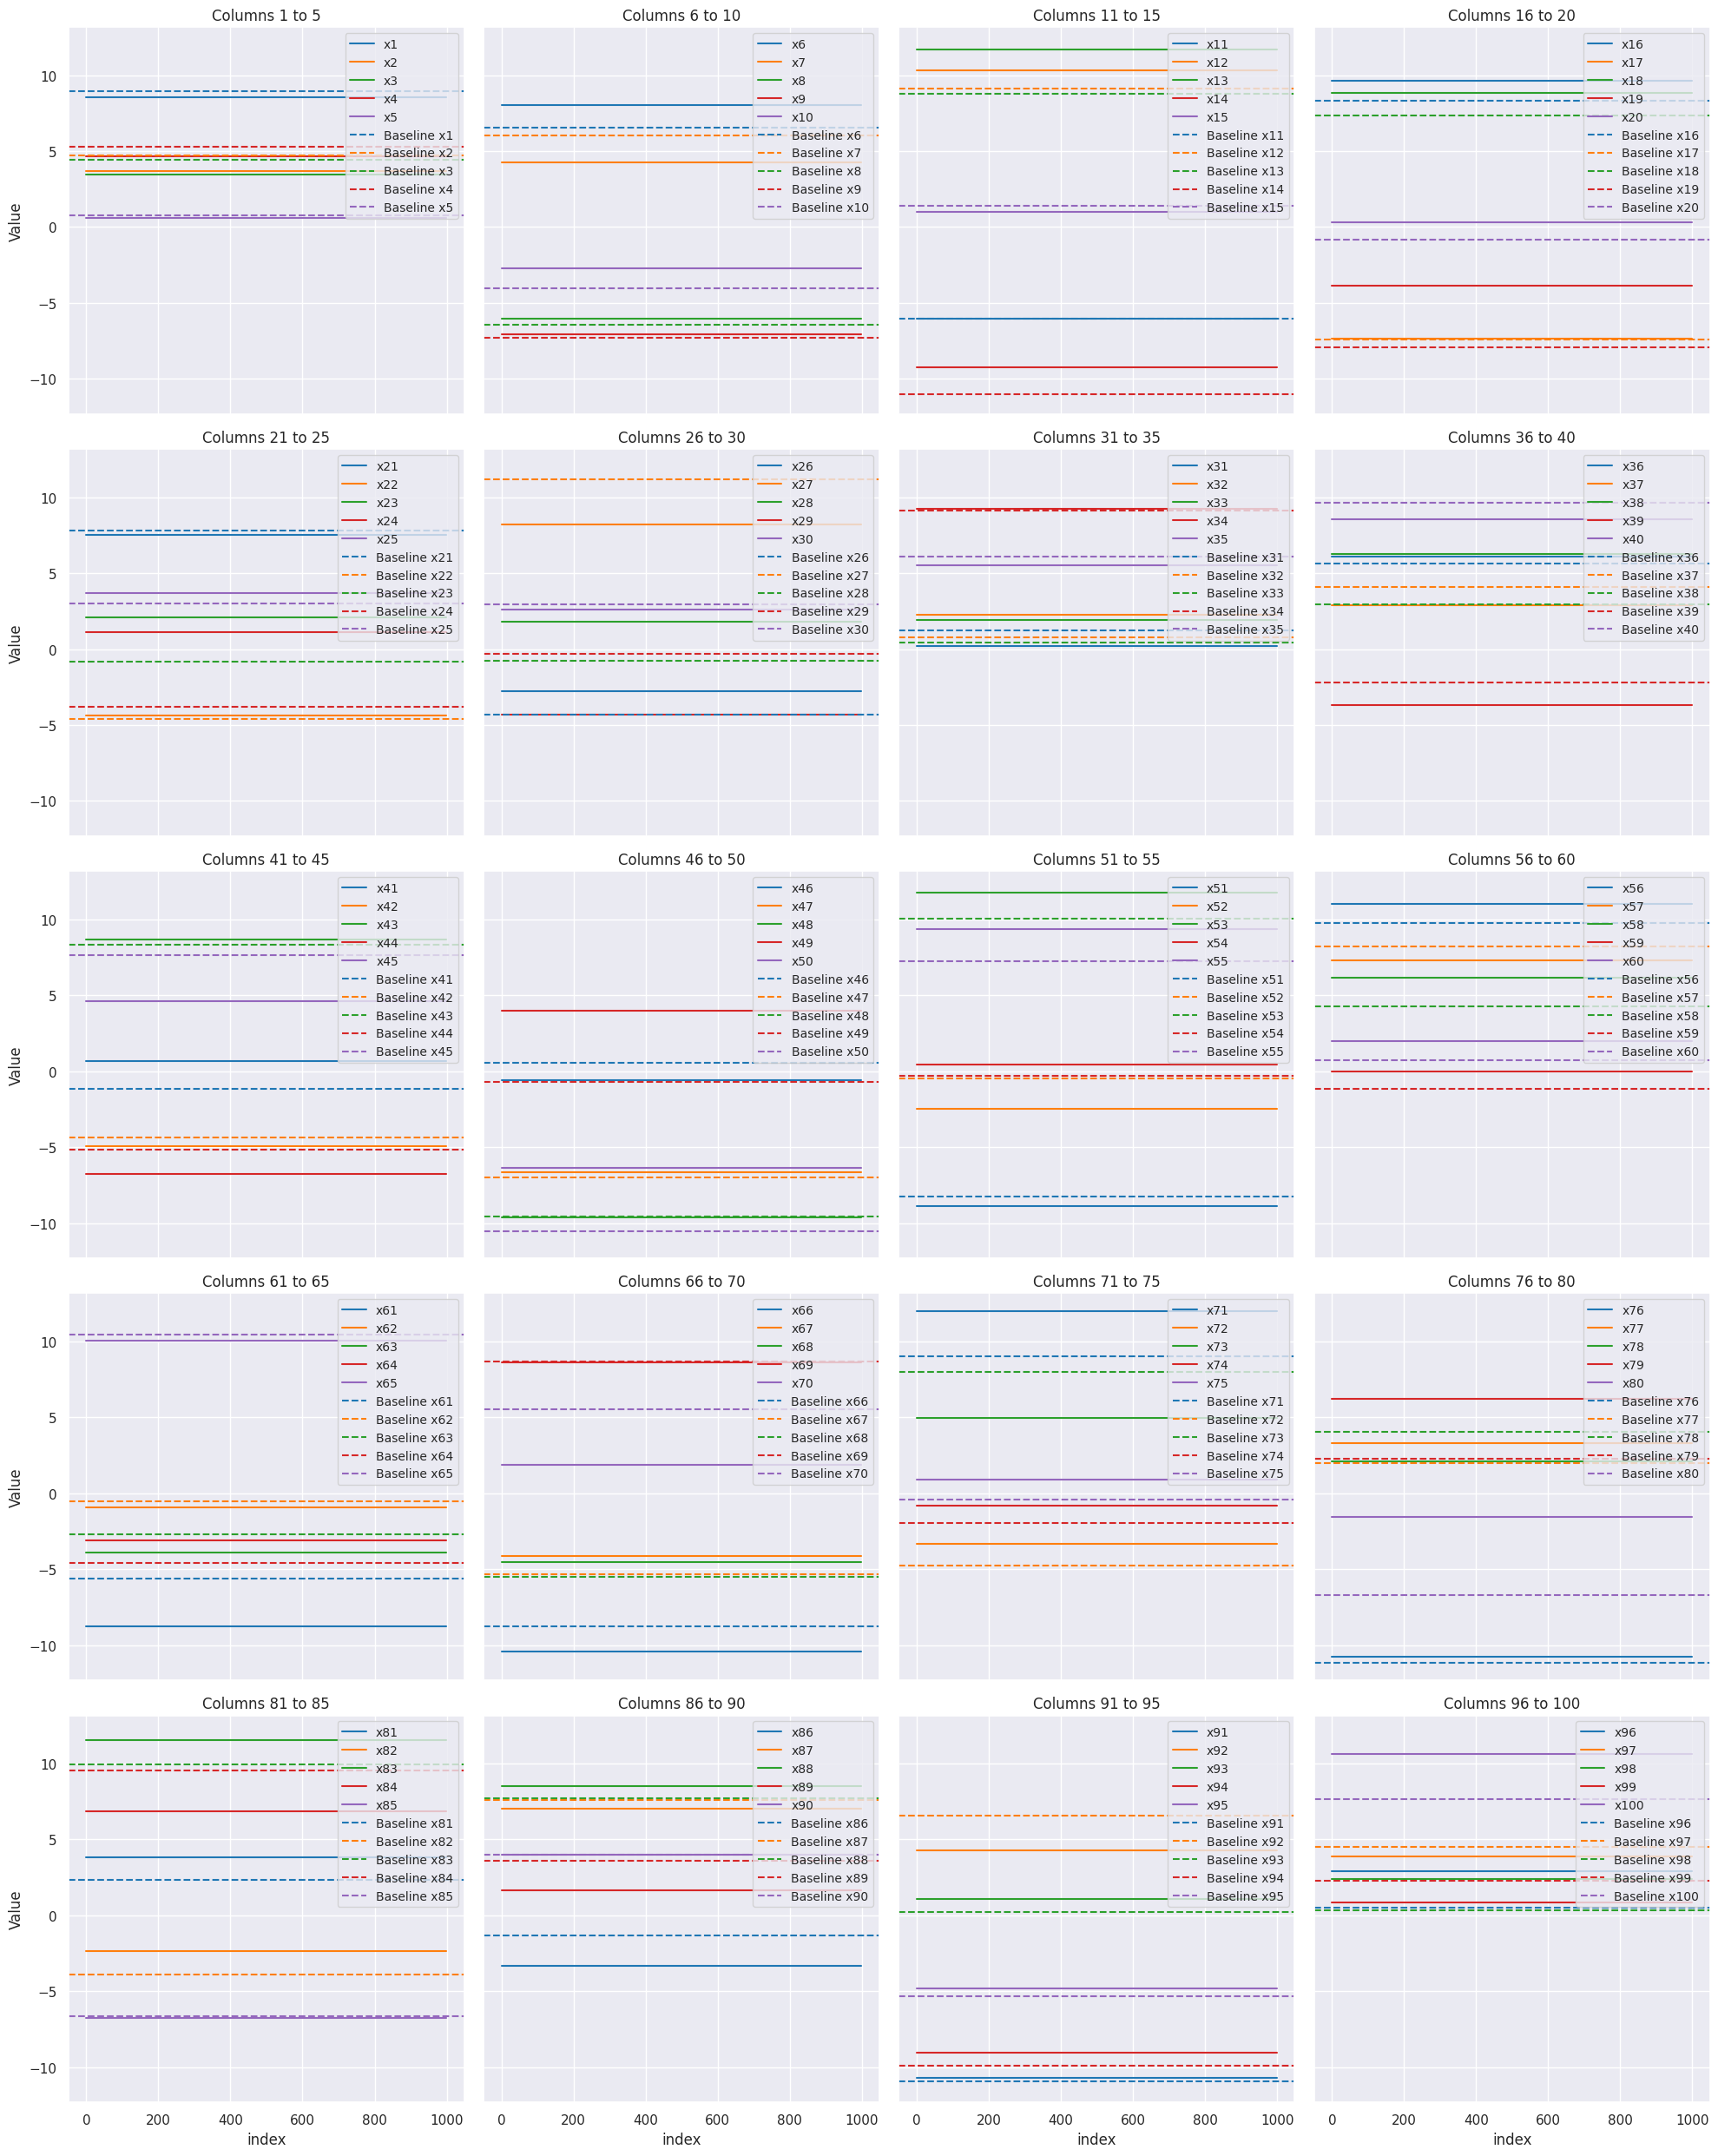

In [110]:
# Create a 5x4 grid of subplots (20 subplots total)
fig, axes = plt.subplots(5, 4, figsize=(20, 25), sharex=True, sharey=True)
axes = axes.flatten()

n_groups = 20
cols_per_group = 5

for i in range(n_groups):
    start = i * cols_per_group
    end = start + cols_per_group
    subset = backfit_df.iloc[:, start:end]
    
    # Convert the subset to long format to easily plot with seaborn and retain legend
    subset_long = subset.reset_index().melt(id_vars='index', var_name='Coefficient', value_name='Value')
    
    # Use a fixed palette for consistency between data and baseline lines
    palette = sns.color_palette("tab10", n_colors=cols_per_group)
    
    # Plot the data lines with seaborn. The hue mapping uses our palette.
    sns.lineplot(data=subset_long, x='index', y='Value', hue='Coefficient', ax=axes[i], palette=palette)
    
    # Plot baseline lines for each column in the group.
    # Each baseline is drawn as a dashed horizontal line at the coefficient value.
    for idx, col in enumerate(subset.columns):
        baseline_val = results.params.iloc[start + idx]
        axes[i].axhline(y=baseline_val, color=palette[idx], linestyle='--', label=f"Baseline {col}")
    
    axes[i].set_title(f"Columns {start+1} to {end}")
    axes[i].legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

Looking at the plots above we can see that a lot of backfit approximated coefficients fall pretty close to the baseline set by multiple regression.

And that it converged in around 2 or 3 iterations even though we had $100$ predictors.